# Afriat

In [1]:
ood_seed = 17

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('36', 'Pericentral', 'Infected')


Removed datapoint: 364

train         15006
validation     3683
ood             364
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 54%|█████▍    | 10329/19053 [00:00<00:00, 103282.22it/s]

100%|██████████| 19053/19053 [00:00<00:00, 103398.85it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1111569.61it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 273.16it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:09<1:01:44,  9.28s/it]

Epoch 1/400:   0%|          | 1/400 [00:09<1:01:44,  9.28s/it, v_num=1, recon=3.95e+3, r2_mean=0.206, adv_loss=3.32, acc_pert=0.257, acc_zone=0.717, acc_status_control=0.501]

Epoch 2/400:   0%|          | 1/400 [00:09<1:01:44,  9.28s/it, v_num=1, recon=3.95e+3, r2_mean=0.206, adv_loss=3.32, acc_pert=0.257, acc_zone=0.717, acc_status_control=0.501]

Epoch 2/400:   0%|          | 2/400 [00:18<59:43,  9.00s/it, v_num=1, recon=3.95e+3, r2_mean=0.206, adv_loss=3.32, acc_pert=0.257, acc_zone=0.717, acc_status_control=0.501]  

Epoch 2/400:   0%|          | 2/400 [00:18<59:43,  9.00s/it, v_num=1, recon=3.24e+3, r2_mean=0.619, adv_loss=2.87, acc_pert=0.368, acc_zone=0.815, acc_status_control=0.643]

Epoch 3/400:   0%|          | 2/400 [00:18<59:43,  9.00s/it, v_num=1, recon=3.24e+3, r2_mean=0.619, adv_loss=2.87, acc_pert=0.368, acc_zone=0.815, acc_status_control=0.643]

Epoch 3/400:   1%|          | 3/400 [00:26<58:57,  8.91s/it, v_num=1, recon=3.24e+3, r2_mean=0.619, adv_loss=2.87, acc_pert=0.368, acc_zone=0.815, acc_status_control=0.643]

Epoch 3/400:   1%|          | 3/400 [00:26<58:57,  8.91s/it, v_num=1, recon=3.19e+3, r2_mean=0.72, adv_loss=2.73, acc_pert=0.396, acc_zone=0.832, acc_status_control=0.645] 

Epoch 4/400:   1%|          | 3/400 [00:26<58:57,  8.91s/it, v_num=1, recon=3.19e+3, r2_mean=0.72, adv_loss=2.73, acc_pert=0.396, acc_zone=0.832, acc_status_control=0.645]

Epoch 4/400:   1%|          | 4/400 [00:35<58:41,  8.89s/it, v_num=1, recon=3.19e+3, r2_mean=0.72, adv_loss=2.73, acc_pert=0.396, acc_zone=0.832, acc_status_control=0.645]

Epoch 4/400:   1%|          | 4/400 [00:35<58:41,  8.89s/it, v_num=1, recon=3.17e+3, r2_mean=0.755, adv_loss=2.65, acc_pert=0.437, acc_zone=0.836, acc_status_control=0.63]

Epoch 5/400:   1%|          | 4/400 [00:35<58:41,  8.89s/it, v_num=1, recon=3.17e+3, r2_mean=0.755, adv_loss=2.65, acc_pert=0.437, acc_zone=0.836, acc_status_control=0.63]

Epoch 5/400:   1%|▏         | 5/400 [00:44<58:25,  8.87s/it, v_num=1, recon=3.17e+3, r2_mean=0.755, adv_loss=2.65, acc_pert=0.437, acc_zone=0.836, acc_status_control=0.63]

Epoch 5/400:   1%|▏         | 5/400 [00:44<58:25,  8.87s/it, v_num=1, recon=3.15e+3, r2_mean=0.778, adv_loss=2.45, acc_pert=0.52, acc_zone=0.837, acc_status_control=0.628]

Epoch 6/400:   1%|▏         | 5/400 [00:44<58:25,  8.87s/it, v_num=1, recon=3.15e+3, r2_mean=0.778, adv_loss=2.45, acc_pert=0.52, acc_zone=0.837, acc_status_control=0.628]

Epoch 6/400:   2%|▏         | 6/400 [00:53<58:17,  8.88s/it, v_num=1, recon=3.15e+3, r2_mean=0.778, adv_loss=2.45, acc_pert=0.52, acc_zone=0.837, acc_status_control=0.628]

Epoch 6/400:   2%|▏         | 6/400 [00:53<58:17,  8.88s/it, v_num=1, recon=3.14e+3, r2_mean=0.793, adv_loss=2.29, acc_pert=0.569, acc_zone=0.841, acc_status_control=0.637]

Epoch 7/400:   2%|▏         | 6/400 [00:53<58:17,  8.88s/it, v_num=1, recon=3.14e+3, r2_mean=0.793, adv_loss=2.29, acc_pert=0.569, acc_zone=0.841, acc_status_control=0.637]

Epoch 7/400:   2%|▏         | 7/400 [01:02<58:04,  8.87s/it, v_num=1, recon=3.14e+3, r2_mean=0.793, adv_loss=2.29, acc_pert=0.569, acc_zone=0.841, acc_status_control=0.637]

Epoch 7/400:   2%|▏         | 7/400 [01:02<58:04,  8.87s/it, v_num=1, recon=3.13e+3, r2_mean=0.802, adv_loss=2.23, acc_pert=0.584, acc_zone=0.849, acc_status_control=0.636]

Epoch 8/400:   2%|▏         | 7/400 [01:02<58:04,  8.87s/it, v_num=1, recon=3.13e+3, r2_mean=0.802, adv_loss=2.23, acc_pert=0.584, acc_zone=0.849, acc_status_control=0.636]

Epoch 8/400:   2%|▏         | 8/400 [01:11<57:52,  8.86s/it, v_num=1, recon=3.13e+3, r2_mean=0.802, adv_loss=2.23, acc_pert=0.584, acc_zone=0.849, acc_status_control=0.636]

Epoch 8/400:   2%|▏         | 8/400 [01:11<57:52,  8.86s/it, v_num=1, recon=3.13e+3, r2_mean=0.805, adv_loss=2.12, acc_pert=0.625, acc_zone=0.854, acc_status_control=0.639]

Epoch 9/400:   2%|▏         | 8/400 [01:11<57:52,  8.86s/it, v_num=1, recon=3.13e+3, r2_mean=0.805, adv_loss=2.12, acc_pert=0.625, acc_zone=0.854, acc_status_control=0.639]

Epoch 9/400:   2%|▏         | 9/400 [01:20<57:44,  8.86s/it, v_num=1, recon=3.13e+3, r2_mean=0.805, adv_loss=2.12, acc_pert=0.625, acc_zone=0.854, acc_status_control=0.639]

Epoch 9/400:   2%|▏         | 9/400 [01:20<57:44,  8.86s/it, v_num=1, recon=3.12e+3, r2_mean=0.813, adv_loss=2.06, acc_pert=0.639, acc_zone=0.857, acc_status_control=0.641]

Epoch 10/400:   2%|▏         | 9/400 [01:20<57:44,  8.86s/it, v_num=1, recon=3.12e+3, r2_mean=0.813, adv_loss=2.06, acc_pert=0.639, acc_zone=0.857, acc_status_control=0.641]


disnt_basal = 1.2340741888113693

disnt_after = 1.904066717842397

val_r2_mean = 0.8114746860512038

val_r2_var = 0.1747741618176059


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [01:33<1:06:42, 10.26s/it, v_num=1, recon=3.12e+3, r2_mean=0.813, adv_loss=2.06, acc_pert=0.639, acc_zone=0.857, acc_status_control=0.641]

Epoch 10/400:   2%|▎         | 10/400 [01:33<1:06:42, 10.26s/it, v_num=1, recon=3.11e+3, r2_mean=0.816, adv_loss=2.07, acc_pert=0.643, acc_zone=0.855, acc_status_control=0.643, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [01:33<1:06:42, 10.26s/it, v_num=1, recon=3.11e+3, r2_mean=0.816, adv_loss=2.07, acc_pert=0.643, acc_zone=0.855, acc_status_control=0.643, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:42<1:03:45,  9.83s/it, v_num=1, recon=3.11e+3, r2_mean=0.816, adv_loss=2.07, acc_pert=0.643, acc_zone=0.855, acc_status_control=0.643, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:42<1:03:45,  9.83s/it, v_num=1, recon=3.11e+3, r2_mean=0.815, adv_loss=2.03, acc_pert=0.652, acc_zone=0.858, acc_status_control=0.644, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [01:42<1:03:45,  9.83s/it, v_num=1, recon=3.11e+3, r2_mean=0.815, adv_loss=2.03, acc_pert=0.652, acc_zone=0.858, acc_status_control=0.644, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:51<1:01:32,  9.52s/it, v_num=1, recon=3.11e+3, r2_mean=0.815, adv_loss=2.03, acc_pert=0.652, acc_zone=0.858, acc_status_control=0.644, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:51<1:01:32,  9.52s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=2, acc_pert=0.665, acc_zone=0.858, acc_status_control=0.647, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]    

Epoch 13/400:   3%|▎         | 12/400 [01:51<1:01:32,  9.52s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=2, acc_pert=0.665, acc_zone=0.858, acc_status_control=0.647, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:59<59:59,  9.30s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=2, acc_pert=0.665, acc_zone=0.858, acc_status_control=0.647, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]  

Epoch 13/400:   3%|▎         | 13/400 [01:59<59:59,  9.30s/it, v_num=1, recon=3.1e+3, r2_mean=0.821, adv_loss=2, acc_pert=0.67, acc_zone=0.864, acc_status_control=0.644, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan] 

Epoch 14/400:   3%|▎         | 13/400 [01:59<59:59,  9.30s/it, v_num=1, recon=3.1e+3, r2_mean=0.821, adv_loss=2, acc_pert=0.67, acc_zone=0.864, acc_status_control=0.644, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:08<58:51,  9.15s/it, v_num=1, recon=3.1e+3, r2_mean=0.821, adv_loss=2, acc_pert=0.67, acc_zone=0.864, acc_status_control=0.644, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:08<58:51,  9.15s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=2.01, acc_pert=0.671, acc_zone=0.859, acc_status_control=0.647, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:08<58:51,  9.15s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=2.01, acc_pert=0.671, acc_zone=0.859, acc_status_control=0.647, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:17<58:03,  9.05s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=2.01, acc_pert=0.671, acc_zone=0.859, acc_status_control=0.647, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:17<58:03,  9.05s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=1.99, acc_pert=0.67, acc_zone=0.862, acc_status_control=0.649, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan] 

Epoch 16/400:   4%|▍         | 15/400 [02:17<58:03,  9.05s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=1.99, acc_pert=0.67, acc_zone=0.862, acc_status_control=0.649, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:26<57:18,  8.95s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=1.99, acc_pert=0.67, acc_zone=0.862, acc_status_control=0.649, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:26<57:18,  8.95s/it, v_num=1, recon=3.08e+3, r2_mean=0.822, adv_loss=1.97, acc_pert=0.679, acc_zone=0.859, acc_status_control=0.659, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [02:26<57:18,  8.95s/it, v_num=1, recon=3.08e+3, r2_mean=0.822, adv_loss=1.97, acc_pert=0.679, acc_zone=0.859, acc_status_control=0.659, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:35<56:58,  8.92s/it, v_num=1, recon=3.08e+3, r2_mean=0.822, adv_loss=1.97, acc_pert=0.679, acc_zone=0.859, acc_status_control=0.659, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:35<56:58,  8.92s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=1.95, acc_pert=0.689, acc_zone=0.859, acc_status_control=0.658, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [02:35<56:58,  8.92s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=1.95, acc_pert=0.689, acc_zone=0.859, acc_status_control=0.658, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:43<56:38,  8.90s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=1.95, acc_pert=0.689, acc_zone=0.859, acc_status_control=0.658, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:43<56:38,  8.90s/it, v_num=1, recon=3.07e+3, r2_mean=0.826, adv_loss=1.93, acc_pert=0.692, acc_zone=0.862, acc_status_control=0.66, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan] 

Epoch 19/400:   4%|▍         | 18/400 [02:43<56:38,  8.90s/it, v_num=1, recon=3.07e+3, r2_mean=0.826, adv_loss=1.93, acc_pert=0.692, acc_zone=0.862, acc_status_control=0.66, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:52<56:14,  8.86s/it, v_num=1, recon=3.07e+3, r2_mean=0.826, adv_loss=1.93, acc_pert=0.692, acc_zone=0.862, acc_status_control=0.66, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:52<56:14,  8.86s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.94, acc_pert=0.688, acc_zone=0.859, acc_status_control=0.661, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [02:52<56:14,  8.86s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.94, acc_pert=0.688, acc_zone=0.859, acc_status_control=0.661, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]


disnt_basal = 1.2411471823765818

disnt_after = 1.8949078532182546

val_r2_mean = 0.8278717477542739

val_r2_var = 0.23151742906361467


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [03:06<1:05:01, 10.27s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.94, acc_pert=0.688, acc_zone=0.859, acc_status_control=0.661, val_recon=3.11e+3, disnt_basal=1.23, disnt_after=1.9, val_r2_mean=0.811, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [03:06<1:05:01, 10.27s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.93, acc_pert=0.692, acc_zone=0.857, acc_status_control=0.661, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [03:06<1:05:01, 10.27s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.93, acc_pert=0.692, acc_zone=0.857, acc_status_control=0.661, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:15<1:02:06,  9.83s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.93, acc_pert=0.692, acc_zone=0.857, acc_status_control=0.661, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:15<1:02:06,  9.83s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.93, acc_pert=0.683, acc_zone=0.86, acc_status_control=0.664, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 22/400:   5%|▌         | 21/400 [03:15<1:02:06,  9.83s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.93, acc_pert=0.683, acc_zone=0.86, acc_status_control=0.664, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:23<1:00:00,  9.53s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.93, acc_pert=0.683, acc_zone=0.86, acc_status_control=0.664, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:23<1:00:00,  9.53s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=1.95, acc_pert=0.678, acc_zone=0.86, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [03:23<1:00:00,  9.53s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=1.95, acc_pert=0.678, acc_zone=0.86, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:32<58:36,  9.33s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=1.95, acc_pert=0.678, acc_zone=0.86, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]  

Epoch 23/400:   6%|▌         | 23/400 [03:32<58:36,  9.33s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.93, acc_pert=0.68, acc_zone=0.858, acc_status_control=0.666, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [03:32<58:36,  9.33s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.93, acc_pert=0.68, acc_zone=0.858, acc_status_control=0.666, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:41<57:29,  9.17s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.93, acc_pert=0.68, acc_zone=0.858, acc_status_control=0.666, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:41<57:29,  9.17s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.95, acc_pert=0.679, acc_zone=0.856, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [03:41<57:29,  9.17s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.95, acc_pert=0.679, acc_zone=0.856, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:50<56:35,  9.06s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.95, acc_pert=0.679, acc_zone=0.856, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:50<56:35,  9.06s/it, v_num=1, recon=3.05e+3, r2_mean=0.83, adv_loss=1.93, acc_pert=0.682, acc_zone=0.857, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 26/400:   6%|▋         | 25/400 [03:50<56:35,  9.06s/it, v_num=1, recon=3.05e+3, r2_mean=0.83, adv_loss=1.93, acc_pert=0.682, acc_zone=0.857, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [03:59<55:56,  8.98s/it, v_num=1, recon=3.05e+3, r2_mean=0.83, adv_loss=1.93, acc_pert=0.682, acc_zone=0.857, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [03:59<55:56,  8.98s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.92, acc_pert=0.68, acc_zone=0.857, acc_status_control=0.67, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 27/400:   6%|▋         | 26/400 [03:59<55:56,  8.98s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.92, acc_pert=0.68, acc_zone=0.857, acc_status_control=0.67, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:07<55:22,  8.91s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.92, acc_pert=0.68, acc_zone=0.857, acc_status_control=0.67, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:07<55:22,  8.91s/it, v_num=1, recon=3.04e+3, r2_mean=0.833, adv_loss=1.93, acc_pert=0.68, acc_zone=0.857, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [04:07<55:22,  8.91s/it, v_num=1, recon=3.04e+3, r2_mean=0.833, adv_loss=1.93, acc_pert=0.68, acc_zone=0.857, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:16<55:10,  8.90s/it, v_num=1, recon=3.04e+3, r2_mean=0.833, adv_loss=1.93, acc_pert=0.68, acc_zone=0.857, acc_status_control=0.667, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:16<55:10,  8.90s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=1.94, acc_pert=0.676, acc_zone=0.856, acc_status_control=0.666, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [04:16<55:10,  8.90s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=1.94, acc_pert=0.676, acc_zone=0.856, acc_status_control=0.666, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:25<55:00,  8.90s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=1.94, acc_pert=0.676, acc_zone=0.856, acc_status_control=0.666, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:25<55:00,  8.90s/it, v_num=1, recon=3.04e+3, r2_mean=0.83, adv_loss=1.96, acc_pert=0.668, acc_zone=0.854, acc_status_control=0.665, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 30/400:   7%|▋         | 29/400 [04:25<55:00,  8.90s/it, v_num=1, recon=3.04e+3, r2_mean=0.83, adv_loss=1.96, acc_pert=0.668, acc_zone=0.854, acc_status_control=0.665, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.2445314781218082

disnt_after = 1.8933441415417338

val_r2_mean = 0.8296514218239112

val_r2_var = 0.23673980150412588

Epoch 30/400:   8%|▊         | 30/400 [04:39<1:03:25, 10.29s/it, v_num=1, recon=3.04e+3, r2_mean=0.83, adv_loss=1.96, acc_pert=0.668, acc_zone=0.854, acc_status_control=0.665, val_recon=3.07e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [04:39<1:03:25, 10.29s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=1.91, acc_pert=0.683, acc_zone=0.858, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [04:39<1:03:25, 10.29s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=1.91, acc_pert=0.683, acc_zone=0.858, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [04:48<1:00:39,  9.86s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=1.91, acc_pert=0.683, acc_zone=0.858, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [04:48<1:00:39,  9.86s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=1.93, acc_pert=0.678, acc_zone=0.858, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [04:48<1:00:39,  9.86s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=1.93, acc_pert=0.678, acc_zone=0.858, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [04:56<58:45,  9.58s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=1.93, acc_pert=0.678, acc_zone=0.858, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]  

Epoch 32/400:   8%|▊         | 32/400 [04:56<58:45,  9.58s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=1.94, acc_pert=0.68, acc_zone=0.856, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan] 

Epoch 33/400:   8%|▊         | 32/400 [04:56<58:45,  9.58s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=1.94, acc_pert=0.68, acc_zone=0.856, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:05<57:33,  9.41s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=1.94, acc_pert=0.68, acc_zone=0.856, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:06<57:33,  9.41s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=1.94, acc_pert=0.673, acc_zone=0.859, acc_status_control=0.671, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [05:06<57:33,  9.41s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=1.94, acc_pert=0.673, acc_zone=0.859, acc_status_control=0.671, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:15<57:11,  9.38s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=1.94, acc_pert=0.673, acc_zone=0.859, acc_status_control=0.671, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:15<57:11,  9.38s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=1.95, acc_pert=0.672, acc_zone=0.862, acc_status_control=0.677, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [05:15<57:11,  9.38s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=1.95, acc_pert=0.672, acc_zone=0.862, acc_status_control=0.677, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:24<56:06,  9.22s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=1.95, acc_pert=0.672, acc_zone=0.862, acc_status_control=0.677, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:24<56:06,  9.22s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=1.98, acc_pert=0.662, acc_zone=0.86, acc_status_control=0.668, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [05:24<56:06,  9.22s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=1.98, acc_pert=0.662, acc_zone=0.86, acc_status_control=0.668, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:32<55:16,  9.11s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=1.98, acc_pert=0.662, acc_zone=0.86, acc_status_control=0.668, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:32<55:16,  9.11s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=1.97, acc_pert=0.661, acc_zone=0.858, acc_status_control=0.673, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [05:32<55:16,  9.11s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=1.97, acc_pert=0.661, acc_zone=0.858, acc_status_control=0.673, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:41<54:41,  9.04s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=1.97, acc_pert=0.661, acc_zone=0.858, acc_status_control=0.673, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:41<54:41,  9.04s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=1.98, acc_pert=0.659, acc_zone=0.859, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [05:41<54:41,  9.04s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=1.98, acc_pert=0.659, acc_zone=0.859, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:50<54:14,  8.99s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=1.98, acc_pert=0.659, acc_zone=0.859, acc_status_control=0.669, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:50<54:14,  8.99s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=1.99, acc_pert=0.649, acc_zone=0.858, acc_status_control=0.673, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [05:50<54:14,  8.99s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=1.99, acc_pert=0.649, acc_zone=0.858, acc_status_control=0.673, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [05:59<53:48,  8.94s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=1.99, acc_pert=0.649, acc_zone=0.858, acc_status_control=0.673, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [05:59<53:48,  8.94s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2, acc_pert=0.65, acc_zone=0.857, acc_status_control=0.672, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]    

Epoch 40/400:  10%|▉         | 39/400 [05:59<53:48,  8.94s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2, acc_pert=0.65, acc_zone=0.857, acc_status_control=0.672, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2253383265026936

disnt_after = 1.8905362429764192

val_r2_mean = 0.8283614025248236

val_r2_var = 0.25851028949715027


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [06:13<1:01:51, 10.31s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2, acc_pert=0.65, acc_zone=0.857, acc_status_control=0.672, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.83, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [06:13<1:01:51, 10.31s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.01, acc_pert=0.643, acc_zone=0.858, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [06:13<1:01:51, 10.31s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.01, acc_pert=0.643, acc_zone=0.858, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [06:21<59:12,  9.90s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.01, acc_pert=0.643, acc_zone=0.858, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]  

Epoch 41/400:  10%|█         | 41/400 [06:21<59:12,  9.90s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.02, acc_pert=0.643, acc_zone=0.855, acc_status_control=0.67, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 42/400:  10%|█         | 41/400 [06:22<59:12,  9.90s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.02, acc_pert=0.643, acc_zone=0.855, acc_status_control=0.67, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:30<57:19,  9.61s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.02, acc_pert=0.643, acc_zone=0.855, acc_status_control=0.67, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:30<57:19,  9.61s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.02, acc_pert=0.641, acc_zone=0.86, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [06:30<57:19,  9.61s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.02, acc_pert=0.641, acc_zone=0.86, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:39<55:54,  9.40s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.02, acc_pert=0.641, acc_zone=0.86, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:39<55:54,  9.40s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.02, acc_pert=0.648, acc_zone=0.855, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]  

Epoch 44/400:  11%|█         | 43/400 [06:39<55:54,  9.40s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.02, acc_pert=0.648, acc_zone=0.855, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:48<54:52,  9.25s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.02, acc_pert=0.648, acc_zone=0.855, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:48<54:52,  9.25s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=2.02, acc_pert=0.636, acc_zone=0.856, acc_status_control=0.67, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 45/400:  11%|█         | 44/400 [06:48<54:52,  9.25s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=2.02, acc_pert=0.636, acc_zone=0.856, acc_status_control=0.67, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [06:57<54:05,  9.14s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=2.02, acc_pert=0.636, acc_zone=0.856, acc_status_control=0.67, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [06:57<54:05,  9.14s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.02, acc_pert=0.634, acc_zone=0.858, acc_status_control=0.671, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [06:57<54:05,  9.14s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.02, acc_pert=0.634, acc_zone=0.858, acc_status_control=0.671, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:06<53:18,  9.03s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.02, acc_pert=0.634, acc_zone=0.858, acc_status_control=0.671, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:06<53:18,  9.03s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.03, acc_pert=0.634, acc_zone=0.86, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan] 

Epoch 47/400:  12%|█▏        | 46/400 [07:06<53:18,  9.03s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.03, acc_pert=0.634, acc_zone=0.86, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:15<52:52,  8.99s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.03, acc_pert=0.634, acc_zone=0.86, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:15<52:52,  8.99s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.03, acc_pert=0.63, acc_zone=0.856, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [07:15<52:52,  8.99s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.03, acc_pert=0.63, acc_zone=0.856, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:24<52:26,  8.94s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.03, acc_pert=0.63, acc_zone=0.856, acc_status_control=0.669, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:24<52:26,  8.94s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.04, acc_pert=0.629, acc_zone=0.857, acc_status_control=0.674, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [07:24<52:26,  8.94s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.04, acc_pert=0.629, acc_zone=0.857, acc_status_control=0.674, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [07:33<52:12,  8.92s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.04, acc_pert=0.629, acc_zone=0.857, acc_status_control=0.674, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [07:33<52:12,  8.92s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.06, acc_pert=0.628, acc_zone=0.855, acc_status_control=0.671, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [07:33<52:12,  8.92s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.06, acc_pert=0.628, acc_zone=0.855, acc_status_control=0.671, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.2294760021108957

disnt_after = 1.8855803011858134

val_r2_mean = 0.832107918412682

val_r2_var = 0.26485591199356906

Epoch 50/400:  12%|█▎        | 50/400 [07:46<1:00:19, 10.34s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.06, acc_pert=0.628, acc_zone=0.855, acc_status_control=0.671, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.828, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [07:46<1:00:19, 10.34s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.63, acc_zone=0.856, acc_status_control=0.667, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]    

Epoch 51/400:  12%|█▎        | 50/400 [07:46<1:00:19, 10.34s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.63, acc_zone=0.856, acc_status_control=0.667, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [07:55<57:31,  9.89s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.63, acc_zone=0.856, acc_status_control=0.667, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]  

Epoch 51/400:  13%|█▎        | 51/400 [07:55<57:31,  9.89s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.06, acc_pert=0.625, acc_zone=0.855, acc_status_control=0.669, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [07:55<57:31,  9.89s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.06, acc_pert=0.625, acc_zone=0.855, acc_status_control=0.669, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [08:04<55:30,  9.57s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.06, acc_pert=0.625, acc_zone=0.855, acc_status_control=0.669, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [08:04<55:30,  9.57s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.05, acc_pert=0.622, acc_zone=0.856, acc_status_control=0.67, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan] 

Epoch 53/400:  13%|█▎        | 52/400 [08:04<55:30,  9.57s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.05, acc_pert=0.622, acc_zone=0.856, acc_status_control=0.67, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:13<54:03,  9.35s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.05, acc_pert=0.622, acc_zone=0.856, acc_status_control=0.67, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:13<54:03,  9.35s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.05, acc_pert=0.622, acc_zone=0.853, acc_status_control=0.67, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [08:13<54:03,  9.35s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.05, acc_pert=0.622, acc_zone=0.853, acc_status_control=0.67, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:21<53:01,  9.20s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.05, acc_pert=0.622, acc_zone=0.853, acc_status_control=0.67, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:21<53:01,  9.20s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.07, acc_pert=0.617, acc_zone=0.854, acc_status_control=0.668, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [08:21<53:01,  9.20s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.07, acc_pert=0.617, acc_zone=0.854, acc_status_control=0.668, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [08:30<52:15,  9.09s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.07, acc_pert=0.617, acc_zone=0.854, acc_status_control=0.668, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [08:30<52:15,  9.09s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.07, acc_pert=0.619, acc_zone=0.857, acc_status_control=0.668, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [08:30<52:15,  9.09s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.07, acc_pert=0.619, acc_zone=0.857, acc_status_control=0.668, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [08:39<51:42,  9.02s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.07, acc_pert=0.619, acc_zone=0.857, acc_status_control=0.668, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [08:39<51:42,  9.02s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.62, acc_zone=0.856, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan] 

Epoch 57/400:  14%|█▍        | 56/400 [08:39<51:42,  9.02s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.62, acc_zone=0.856, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [08:48<51:17,  8.97s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.62, acc_zone=0.856, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [08:48<51:17,  8.97s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.06, acc_pert=0.625, acc_zone=0.853, acc_status_control=0.669, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [08:48<51:17,  8.97s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.06, acc_pert=0.625, acc_zone=0.853, acc_status_control=0.669, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [08:57<51:05,  8.96s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.06, acc_pert=0.625, acc_zone=0.853, acc_status_control=0.669, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [08:57<51:05,  8.96s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.619, acc_zone=0.852, acc_status_control=0.666, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [08:57<51:05,  8.96s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.619, acc_zone=0.852, acc_status_control=0.666, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:06<50:41,  8.92s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.619, acc_zone=0.852, acc_status_control=0.666, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:06<50:41,  8.92s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.09, acc_pert=0.611, acc_zone=0.852, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [09:06<50:41,  8.92s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.09, acc_pert=0.611, acc_zone=0.852, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.2136189675791162

disnt_after = 1.8930861272170887

val_r2_mean = 0.8326556757530605

val_r2_var = 0.2709548957113942


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [09:19<58:16, 10.28s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.09, acc_pert=0.611, acc_zone=0.852, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [09:19<58:16, 10.28s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.614, acc_zone=0.855, acc_status_control=0.668, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [09:19<58:16, 10.28s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.614, acc_zone=0.855, acc_status_control=0.668, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [09:28<55:38,  9.85s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.614, acc_zone=0.855, acc_status_control=0.668, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [09:28<55:38,  9.85s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.09, acc_pert=0.618, acc_zone=0.853, acc_status_control=0.665, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [09:28<55:38,  9.85s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.09, acc_pert=0.618, acc_zone=0.853, acc_status_control=0.665, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [09:37<53:58,  9.58s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.09, acc_pert=0.618, acc_zone=0.853, acc_status_control=0.665, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [09:37<53:58,  9.58s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.09, acc_pert=0.615, acc_zone=0.853, acc_status_control=0.668, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [09:37<53:58,  9.58s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.09, acc_pert=0.615, acc_zone=0.853, acc_status_control=0.668, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [09:46<52:36,  9.37s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.09, acc_pert=0.615, acc_zone=0.853, acc_status_control=0.668, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [09:46<52:36,  9.37s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.08, acc_pert=0.619, acc_zone=0.852, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan] 

Epoch 64/400:  16%|█▌        | 63/400 [09:46<52:36,  9.37s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.08, acc_pert=0.619, acc_zone=0.852, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [09:55<51:35,  9.21s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.08, acc_pert=0.619, acc_zone=0.852, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [09:55<51:35,  9.21s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.09, acc_pert=0.615, acc_zone=0.853, acc_status_control=0.662, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [09:55<51:35,  9.21s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.09, acc_pert=0.615, acc_zone=0.853, acc_status_control=0.662, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [10:04<50:51,  9.11s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.09, acc_pert=0.615, acc_zone=0.853, acc_status_control=0.662, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [10:04<50:51,  9.11s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.61, acc_zone=0.852, acc_status_control=0.666, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan] 

Epoch 66/400:  16%|█▋        | 65/400 [10:04<50:51,  9.11s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.61, acc_zone=0.852, acc_status_control=0.666, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:13<50:23,  9.05s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.61, acc_zone=0.852, acc_status_control=0.666, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:13<50:23,  9.05s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.615, acc_zone=0.85, acc_status_control=0.667, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [10:13<50:23,  9.05s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.615, acc_zone=0.85, acc_status_control=0.667, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [10:22<50:36,  9.12s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.615, acc_zone=0.85, acc_status_control=0.667, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [10:22<50:36,  9.12s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.1, acc_pert=0.611, acc_zone=0.853, acc_status_control=0.667, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [10:22<50:36,  9.12s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.1, acc_pert=0.611, acc_zone=0.853, acc_status_control=0.667, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [10:31<49:57,  9.03s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.1, acc_pert=0.611, acc_zone=0.853, acc_status_control=0.667, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [10:31<49:57,  9.03s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.12, acc_pert=0.606, acc_zone=0.85, acc_status_control=0.664, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan] 

Epoch 69/400:  17%|█▋        | 68/400 [10:31<49:57,  9.03s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.12, acc_pert=0.606, acc_zone=0.85, acc_status_control=0.664, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [10:39<49:28,  8.97s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.12, acc_pert=0.606, acc_zone=0.85, acc_status_control=0.664, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [10:39<49:28,  8.97s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.605, acc_zone=0.854, acc_status_control=0.664, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [10:39<49:28,  8.97s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.605, acc_zone=0.854, acc_status_control=0.664, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.2139192182217786

disnt_after = 1.887008666146469

val_r2_mean = 0.8321476295968889

val_r2_var = 0.277022328410365

Epoch 70/400:  18%|█▊        | 70/400 [10:53<56:37, 10.30s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.605, acc_zone=0.854, acc_status_control=0.664, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [10:53<56:37, 10.30s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.11, acc_pert=0.603, acc_zone=0.853, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [10:53<56:37, 10.30s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.11, acc_pert=0.603, acc_zone=0.853, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [11:02<54:00,  9.85s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.11, acc_pert=0.603, acc_zone=0.853, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [11:02<54:00,  9.85s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.608, acc_zone=0.85, acc_status_control=0.665, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan] 

Epoch 72/400:  18%|█▊        | 71/400 [11:02<54:00,  9.85s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.608, acc_zone=0.85, acc_status_control=0.665, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:10<52:02,  9.52s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.608, acc_zone=0.85, acc_status_control=0.665, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:10<52:02,  9.52s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.12, acc_pert=0.603, acc_zone=0.849, acc_status_control=0.668, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [11:10<52:02,  9.52s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.12, acc_pert=0.603, acc_zone=0.849, acc_status_control=0.668, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [11:19<50:41,  9.30s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.12, acc_pert=0.603, acc_zone=0.849, acc_status_control=0.668, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [11:19<50:41,  9.30s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.11, acc_pert=0.604, acc_zone=0.85, acc_status_control=0.667, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]  

Epoch 74/400:  18%|█▊        | 73/400 [11:19<50:41,  9.30s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.11, acc_pert=0.604, acc_zone=0.85, acc_status_control=0.667, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [11:28<49:42,  9.15s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.11, acc_pert=0.604, acc_zone=0.85, acc_status_control=0.667, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [11:28<49:42,  9.15s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.12, acc_pert=0.602, acc_zone=0.848, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [11:28<49:42,  9.15s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.12, acc_pert=0.602, acc_zone=0.848, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [11:37<49:02,  9.05s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.12, acc_pert=0.602, acc_zone=0.848, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [11:37<49:02,  9.05s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.602, acc_zone=0.85, acc_status_control=0.669, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan] 

Epoch 76/400:  19%|█▉        | 75/400 [11:37<49:02,  9.05s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.602, acc_zone=0.85, acc_status_control=0.669, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [11:46<48:30,  8.98s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.602, acc_zone=0.85, acc_status_control=0.669, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [11:46<48:30,  8.98s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.602, acc_zone=0.847, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [11:46<48:30,  8.98s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.602, acc_zone=0.847, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [11:54<47:59,  8.91s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.602, acc_zone=0.847, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [11:54<47:59,  8.91s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.599, acc_zone=0.848, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [11:54<47:59,  8.91s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.599, acc_zone=0.848, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [12:03<47:33,  8.86s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.599, acc_zone=0.848, acc_status_control=0.666, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [12:03<47:33,  8.86s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.597, acc_zone=0.85, acc_status_control=0.665, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]  

Epoch 79/400:  20%|█▉        | 78/400 [12:03<47:33,  8.86s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.597, acc_zone=0.85, acc_status_control=0.665, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [12:12<47:18,  8.84s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.597, acc_zone=0.85, acc_status_control=0.665, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [12:12<47:18,  8.84s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.596, acc_zone=0.852, acc_status_control=0.66, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [12:12<47:18,  8.84s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.596, acc_zone=0.852, acc_status_control=0.66, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.2088951794152318

disnt_after = 1.8952516354075966

val_r2_mean = 0.8228654236449301

val_r2_var = 0.2725225146330023


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [12:25<54:22, 10.20s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.596, acc_zone=0.852, acc_status_control=0.66, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [12:25<54:22, 10.20s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.587, acc_zone=0.846, acc_status_control=0.664, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [12:25<54:22, 10.20s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.587, acc_zone=0.846, acc_status_control=0.664, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [12:34<51:58,  9.78s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.587, acc_zone=0.846, acc_status_control=0.664, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [12:34<51:58,  9.78s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.596, acc_zone=0.852, acc_status_control=0.665, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan] 

Epoch 82/400:  20%|██        | 81/400 [12:34<51:58,  9.78s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.596, acc_zone=0.852, acc_status_control=0.665, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [12:43<50:10,  9.47s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.596, acc_zone=0.852, acc_status_control=0.665, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [12:43<50:10,  9.47s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.588, acc_zone=0.851, acc_status_control=0.665, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [12:43<50:10,  9.47s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.588, acc_zone=0.851, acc_status_control=0.665, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [12:52<48:42,  9.22s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.588, acc_zone=0.851, acc_status_control=0.665, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [12:52<48:42,  9.22s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.587, acc_zone=0.849, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [12:52<48:42,  9.22s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.587, acc_zone=0.849, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [13:00<47:46,  9.07s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.587, acc_zone=0.849, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [13:00<47:46,  9.07s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.589, acc_zone=0.849, acc_status_control=0.662, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [13:00<47:46,  9.07s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.589, acc_zone=0.849, acc_status_control=0.662, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [13:09<47:16,  9.01s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.589, acc_zone=0.849, acc_status_control=0.662, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [13:09<47:16,  9.01s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.598, acc_zone=0.85, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]  

Epoch 86/400:  21%|██▏       | 85/400 [13:09<47:16,  9.01s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.598, acc_zone=0.85, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [13:18<46:46,  8.94s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.598, acc_zone=0.85, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [13:18<46:46,  8.94s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.595, acc_zone=0.848, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [13:18<46:46,  8.94s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.595, acc_zone=0.848, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [13:27<46:15,  8.87s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.595, acc_zone=0.848, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [13:27<46:15,  8.87s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.592, acc_zone=0.848, acc_status_control=0.664, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [13:27<46:15,  8.87s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.592, acc_zone=0.848, acc_status_control=0.664, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [13:35<46:01,  8.85s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.592, acc_zone=0.848, acc_status_control=0.664, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [13:35<46:01,  8.85s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.593, acc_zone=0.846, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan] 

Epoch 89/400:  22%|██▏       | 88/400 [13:35<46:01,  8.85s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.593, acc_zone=0.846, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [13:44<45:46,  8.83s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.593, acc_zone=0.846, acc_status_control=0.663, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [13:44<45:46,  8.83s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.588, acc_zone=0.847, acc_status_control=0.666, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [13:44<45:46,  8.83s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.588, acc_zone=0.847, acc_status_control=0.666, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]


disnt_basal = 1.2103131312068833

disnt_after = 1.8875565354909067

val_r2_mean = 0.8318663179629738

val_r2_var = 0.2809854784608832

Epoch 90/400:  22%|██▎       | 90/400 [13:58<52:39, 10.19s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.588, acc_zone=0.847, acc_status_control=0.666, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [13:58<52:39, 10.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.594, acc_zone=0.845, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [13:58<52:39, 10.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.594, acc_zone=0.845, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [14:06<50:11,  9.75s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.594, acc_zone=0.845, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [14:06<50:11,  9.75s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.592, acc_zone=0.847, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [14:06<50:11,  9.75s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.592, acc_zone=0.847, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [14:15<48:32,  9.46s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.592, acc_zone=0.847, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [14:15<48:32,  9.46s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.592, acc_zone=0.845, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [14:15<48:32,  9.46s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.592, acc_zone=0.845, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [14:24<47:14,  9.23s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.592, acc_zone=0.845, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [14:24<47:14,  9.23s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.587, acc_zone=0.846, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [14:24<47:14,  9.23s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.587, acc_zone=0.846, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [14:32<46:21,  9.09s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.587, acc_zone=0.846, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [14:32<46:21,  9.09s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.593, acc_zone=0.843, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [14:32<46:21,  9.09s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.593, acc_zone=0.843, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [14:41<45:48,  9.01s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.593, acc_zone=0.843, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [14:41<45:48,  9.01s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.589, acc_zone=0.848, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [14:41<45:48,  9.01s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.589, acc_zone=0.848, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [14:50<45:16,  8.94s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.589, acc_zone=0.848, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [14:50<45:16,  8.94s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.582, acc_zone=0.844, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [14:50<45:16,  8.94s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.582, acc_zone=0.844, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [14:59<44:50,  8.88s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.582, acc_zone=0.844, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [14:59<44:50,  8.88s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.579, acc_zone=0.845, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [14:59<44:50,  8.88s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.579, acc_zone=0.845, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [15:08<44:28,  8.84s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.579, acc_zone=0.845, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [15:08<44:28,  8.84s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.587, acc_zone=0.847, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan] 

Epoch 99/400:  24%|██▍       | 98/400 [15:08<44:28,  8.84s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.587, acc_zone=0.847, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [15:16<44:18,  8.83s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.587, acc_zone=0.847, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [15:16<44:18,  8.83s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.579, acc_zone=0.846, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [15:16<44:18,  8.83s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.579, acc_zone=0.846, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.21017186808295

disnt_after = 1.885071427553398

val_r2_mean = 0.8327848252614941

val_r2_var = 0.2773313902458482

Epoch 100/400:  25%|██▌       | 100/400 [15:30<51:26, 10.29s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.579, acc_zone=0.846, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.832, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [15:30<51:26, 10.29s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.585, acc_zone=0.846, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [15:30<51:26, 10.29s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.585, acc_zone=0.846, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [15:39<49:11,  9.87s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.585, acc_zone=0.846, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [15:39<49:11,  9.87s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.584, acc_zone=0.85, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]  

Epoch 102/400:  25%|██▌       | 101/400 [15:39<49:11,  9.87s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.584, acc_zone=0.85, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [15:48<47:24,  9.55s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.584, acc_zone=0.85, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [15:48<47:24,  9.55s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.587, acc_zone=0.844, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [15:48<47:24,  9.55s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.587, acc_zone=0.844, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [15:57<46:05,  9.31s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.587, acc_zone=0.844, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [15:57<46:05,  9.31s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.586, acc_zone=0.843, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [15:57<46:05,  9.31s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.586, acc_zone=0.843, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [16:05<45:16,  9.18s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.586, acc_zone=0.843, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [16:05<45:16,  9.18s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.579, acc_zone=0.845, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan] 

Epoch 105/400:  26%|██▌       | 104/400 [16:05<45:16,  9.18s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.579, acc_zone=0.845, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [16:14<44:35,  9.07s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.579, acc_zone=0.845, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [16:14<44:35,  9.07s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [16:14<44:35,  9.07s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [16:23<44:09,  9.01s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [16:23<44:09,  9.01s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.581, acc_zone=0.847, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan] 

Epoch 107/400:  26%|██▋       | 106/400 [16:23<44:09,  9.01s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.581, acc_zone=0.847, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [16:32<43:42,  8.95s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.581, acc_zone=0.847, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [16:32<43:42,  8.95s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.581, acc_zone=0.846, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [16:32<43:42,  8.95s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.581, acc_zone=0.846, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [16:41<43:22,  8.91s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.581, acc_zone=0.846, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [16:41<43:22,  8.91s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.583, acc_zone=0.846, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [16:41<43:22,  8.91s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.583, acc_zone=0.846, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [16:50<43:04,  8.88s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.583, acc_zone=0.846, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [16:50<43:04,  8.88s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.579, acc_zone=0.844, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [16:50<43:04,  8.88s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.579, acc_zone=0.844, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1964730423217

disnt_after = 1.8810662503383033

val_r2_mean = 0.8342046607280265

val_r2_var = 0.28273212442616863


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [17:03<49:17, 10.20s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.579, acc_zone=0.844, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.89, val_r2_mean=0.833, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [17:03<49:17, 10.20s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.582, acc_zone=0.844, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [17:03<49:17, 10.20s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.582, acc_zone=0.844, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [17:12<47:16,  9.82s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.582, acc_zone=0.844, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [17:12<47:16,  9.82s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.579, acc_zone=0.844, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [17:12<47:16,  9.82s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.579, acc_zone=0.844, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [17:21<45:45,  9.53s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.579, acc_zone=0.844, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [17:21<45:45,  9.53s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [17:21<45:45,  9.53s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [17:29<44:31,  9.31s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [17:29<44:31,  9.31s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.581, acc_zone=0.842, acc_status_control=0.669, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [17:29<44:31,  9.31s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.581, acc_zone=0.842, acc_status_control=0.669, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [17:38<43:40,  9.16s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.581, acc_zone=0.842, acc_status_control=0.669, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [17:38<43:40,  9.16s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.579, acc_zone=0.845, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [17:38<43:40,  9.16s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.579, acc_zone=0.845, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [17:47<43:09,  9.08s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.579, acc_zone=0.845, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [17:47<43:09,  9.08s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [17:47<43:09,  9.08s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [17:56<42:32,  8.99s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [17:56<42:32,  8.99s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [17:56<42:32,  8.99s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [18:05<42:01,  8.91s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [18:05<42:01,  8.91s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan] 

Epoch 118/400:  29%|██▉       | 117/400 [18:05<42:01,  8.91s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [18:13<41:41,  8.87s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [18:13<41:41,  8.87s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.579, acc_zone=0.843, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [18:13<41:41,  8.87s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.579, acc_zone=0.843, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [18:22<41:28,  8.86s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.579, acc_zone=0.843, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [18:22<41:28,  8.86s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [18:22<41:28,  8.86s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.2046548150258416

disnt_after = 1.8795056692973526

val_r2_mean = 0.8406204410859278

val_r2_var = 0.29760836571910176

Epoch 120/400:  30%|███       | 120/400 [18:36<47:46, 10.24s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [18:36<47:46, 10.24s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [18:36<47:46, 10.24s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [18:44<45:39,  9.82s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [18:44<45:39,  9.82s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan] 

Epoch 122/400:  30%|███       | 121/400 [18:44<45:39,  9.82s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [18:53<44:06,  9.52s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [18:53<44:06,  9.52s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.58, acc_zone=0.844, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan] 

Epoch 123/400:  30%|███       | 122/400 [18:53<44:06,  9.52s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.58, acc_zone=0.844, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [19:02<43:03,  9.33s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.58, acc_zone=0.844, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [19:02<43:03,  9.33s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.577, acc_zone=0.844, acc_status_control=0.67, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [19:02<43:03,  9.33s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.577, acc_zone=0.844, acc_status_control=0.67, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [19:11<42:15,  9.19s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.577, acc_zone=0.844, acc_status_control=0.67, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [19:11<42:15,  9.19s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.572, acc_zone=0.841, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [19:11<42:15,  9.19s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.572, acc_zone=0.841, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [19:20<41:45,  9.11s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.572, acc_zone=0.841, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [19:20<41:45,  9.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.573, acc_zone=0.842, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan] 

Epoch 126/400:  31%|███▏      | 125/400 [19:20<41:45,  9.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.573, acc_zone=0.842, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [19:29<41:15,  9.04s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.573, acc_zone=0.842, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [19:29<41:15,  9.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [19:29<41:15,  9.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [19:38<40:57,  9.00s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [19:38<40:57,  9.00s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.576, acc_zone=0.842, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan] 

Epoch 128/400:  32%|███▏      | 127/400 [19:38<40:57,  9.00s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.576, acc_zone=0.842, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [19:47<40:42,  8.98s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.576, acc_zone=0.842, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [19:47<40:42,  8.98s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.583, acc_zone=0.843, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [19:47<40:42,  8.98s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.583, acc_zone=0.843, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [19:56<40:25,  8.95s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.583, acc_zone=0.843, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [19:56<40:25,  8.95s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [19:56<40:25,  8.95s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]


disnt_basal = 1.1992259200156488

disnt_after = 1.8874835778624646

val_r2_mean = 0.8308498203771848

val_r2_var = 0.2810855993761206


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [20:09<46:19, 10.29s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.841, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [20:09<46:19, 10.29s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.575, acc_zone=0.847, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [20:09<46:19, 10.29s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.575, acc_zone=0.847, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [20:18<44:08,  9.85s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.575, acc_zone=0.847, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [20:18<44:08,  9.85s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.574, acc_zone=0.841, acc_status_control=0.668, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [20:18<44:08,  9.85s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.574, acc_zone=0.841, acc_status_control=0.668, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [20:27<42:36,  9.54s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.574, acc_zone=0.841, acc_status_control=0.668, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [20:27<42:36,  9.54s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [20:27<42:36,  9.54s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [20:36<41:46,  9.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [20:36<41:46,  9.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.584, acc_zone=0.844, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [20:36<41:46,  9.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.584, acc_zone=0.844, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [20:44<40:47,  9.20s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.584, acc_zone=0.844, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [20:44<40:47,  9.20s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.58, acc_zone=0.841, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan] 

Epoch 135/400:  34%|███▎      | 134/400 [20:44<40:47,  9.20s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.58, acc_zone=0.841, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [20:53<40:03,  9.07s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.58, acc_zone=0.841, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [20:53<40:03,  9.07s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.587, acc_zone=0.842, acc_status_control=0.668, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [20:53<40:03,  9.07s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.587, acc_zone=0.842, acc_status_control=0.668, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [21:02<39:34,  8.99s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.587, acc_zone=0.842, acc_status_control=0.668, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [21:02<39:34,  8.99s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.581, acc_zone=0.841, acc_status_control=0.668, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [21:02<39:34,  8.99s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.581, acc_zone=0.841, acc_status_control=0.668, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [21:11<39:10,  8.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.581, acc_zone=0.841, acc_status_control=0.668, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [21:11<39:10,  8.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.579, acc_zone=0.844, acc_status_control=0.668, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [21:11<39:10,  8.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.579, acc_zone=0.844, acc_status_control=0.668, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [21:20<38:51,  8.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.579, acc_zone=0.844, acc_status_control=0.668, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [21:20<38:51,  8.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.585, acc_zone=0.844, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [21:20<38:51,  8.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.585, acc_zone=0.844, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [21:28<38:37,  8.88s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.585, acc_zone=0.844, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [21:28<38:37,  8.88s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.579, acc_zone=0.845, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [21:28<38:37,  8.88s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.579, acc_zone=0.845, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.184521381538695

disnt_after = 1.8831944404843635

val_r2_mean = 0.8290298839896582

val_r2_var = 0.2927825736642684


Epoch 00139: cpa_metric reached. Module best state updated.


Epoch 140/400:  35%|███▌      | 140/400 [21:42<44:07, 10.18s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.579, acc_zone=0.845, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.89, val_r2_mean=0.831, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [21:42<44:07, 10.18s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.579, acc_zone=0.847, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [21:42<44:07, 10.18s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.579, acc_zone=0.847, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [21:51<42:12,  9.78s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.579, acc_zone=0.847, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [21:51<42:12,  9.78s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.581, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [21:51<42:12,  9.78s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.581, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [21:59<40:41,  9.46s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.581, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [21:59<40:41,  9.46s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.579, acc_zone=0.843, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [21:59<40:41,  9.46s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.579, acc_zone=0.843, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [22:08<39:39,  9.26s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.579, acc_zone=0.843, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [22:08<39:39,  9.26s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.577, acc_zone=0.844, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [22:08<39:39,  9.26s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.577, acc_zone=0.844, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [22:17<38:55,  9.12s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.577, acc_zone=0.844, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [22:17<38:55,  9.12s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.576, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [22:17<38:55,  9.12s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.576, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [22:26<38:21,  9.03s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.576, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [22:26<38:21,  9.03s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.573, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan] 

Epoch 146/400:  36%|███▋      | 145/400 [22:26<38:21,  9.03s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.573, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [22:34<37:51,  8.94s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.573, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [22:34<37:51,  8.94s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.577, acc_zone=0.847, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [22:34<37:51,  8.94s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.577, acc_zone=0.847, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [22:43<37:35,  8.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.577, acc_zone=0.847, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [22:43<37:35,  8.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [22:43<37:35,  8.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [22:52<37:22,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [22:52<37:22,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [22:52<37:22,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [23:01<37:16,  8.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [23:01<37:16,  8.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.573, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [23:01<37:16,  8.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.573, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.19321824862576

disnt_after = 1.8787210519011424

val_r2_mean = 0.8318837723054401

val_r2_var = 0.29541998945554115

Epoch 150/400:  38%|███▊      | 150/400 [23:14<42:43, 10.25s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.573, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [23:14<42:43, 10.25s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [23:14<42:43, 10.25s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [23:23<40:44,  9.82s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [23:23<40:44,  9.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.577, acc_zone=0.846, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [23:23<40:44,  9.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.577, acc_zone=0.846, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [23:32<39:11,  9.48s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.577, acc_zone=0.846, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [23:32<39:11,  9.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [23:32<39:11,  9.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [23:41<38:04,  9.25s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [23:41<38:04,  9.25s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.575, acc_zone=0.844, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [23:41<38:04,  9.25s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.575, acc_zone=0.844, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [23:51<39:01,  9.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.575, acc_zone=0.844, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [23:51<39:01,  9.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.578, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [23:51<39:01,  9.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.578, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [24:01<39:37,  9.70s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.578, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [24:01<39:37,  9.70s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.578, acc_zone=0.845, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [24:01<39:37,  9.70s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.578, acc_zone=0.845, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [24:11<39:55,  9.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.578, acc_zone=0.845, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [24:11<39:55,  9.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [24:11<39:55,  9.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [24:21<40:05,  9.90s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [24:21<40:05,  9.90s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan] 

Epoch 158/400:  39%|███▉      | 157/400 [24:21<40:05,  9.90s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [24:31<40:13,  9.97s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [24:31<40:13,  9.97s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.577, acc_zone=0.839, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [24:31<40:13,  9.97s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.577, acc_zone=0.839, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [24:41<40:12, 10.01s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.577, acc_zone=0.839, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [24:41<40:12, 10.01s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.581, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [24:41<40:12, 10.01s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.581, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1923636426712623

disnt_after = 1.863304152980291

val_r2_mean = 0.8313118051826864

val_r2_var = 0.30675055352229774

Epoch 160/400:  40%|████      | 160/400 [24:56<45:44, 11.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.581, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [24:56<45:44, 11.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [24:56<45:44, 11.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [25:05<42:26, 10.66s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [25:05<42:26, 10.66s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [25:05<42:26, 10.66s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [25:14<40:12, 10.14s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [25:14<40:12, 10.14s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.57, acc_zone=0.845, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan] 

Epoch 163/400:  40%|████      | 162/400 [25:14<40:12, 10.14s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.57, acc_zone=0.845, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [25:23<38:33,  9.76s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.57, acc_zone=0.845, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [25:23<38:33,  9.76s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.574, acc_zone=0.839, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [25:23<38:33,  9.76s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.574, acc_zone=0.839, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [25:32<37:24,  9.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.574, acc_zone=0.839, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [25:32<37:24,  9.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.577, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [25:32<37:24,  9.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.577, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [25:41<36:43,  9.37s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.577, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [25:41<36:43,  9.37s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [25:41<36:43,  9.37s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [25:50<35:59,  9.23s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [25:50<35:59,  9.23s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [25:50<35:59,  9.23s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [25:59<35:34,  9.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [25:59<35:34,  9.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.568, acc_zone=0.847, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [25:59<35:34,  9.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.568, acc_zone=0.847, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [26:07<35:02,  9.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.568, acc_zone=0.847, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [26:07<35:02,  9.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [26:07<35:02,  9.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [26:16<34:38,  9.00s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [26:16<34:38,  9.00s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.576, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan] 

Epoch 170/400:  42%|████▏     | 169/400 [26:16<34:38,  9.00s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.576, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.186331096000158

disnt_after = 1.871951094402841

val_r2_mean = 0.8296683362930205

val_r2_var = 0.2951593441425993

Epoch 170/400:  42%|████▎     | 170/400 [26:30<39:30, 10.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.576, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [26:30<39:30, 10.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.575, acc_zone=0.845, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [26:30<39:30, 10.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.575, acc_zone=0.845, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [26:38<37:36,  9.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.575, acc_zone=0.845, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [26:38<37:36,  9.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.574, acc_zone=0.843, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [26:38<37:36,  9.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.574, acc_zone=0.843, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [26:47<36:18,  9.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.574, acc_zone=0.843, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [26:47<36:18,  9.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.576, acc_zone=0.842, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [26:47<36:18,  9.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.576, acc_zone=0.842, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [26:56<35:22,  9.35s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.576, acc_zone=0.842, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [26:56<35:22,  9.35s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.575, acc_zone=0.845, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [26:56<35:22,  9.35s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.575, acc_zone=0.845, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [27:05<34:31,  9.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.575, acc_zone=0.845, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [27:05<34:31,  9.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.57, acc_zone=0.847, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan] 

Epoch 175/400:  44%|████▎     | 174/400 [27:05<34:31,  9.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.57, acc_zone=0.847, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [27:14<33:58,  9.06s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.57, acc_zone=0.847, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [27:14<33:58,  9.06s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.578, acc_zone=0.841, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [27:14<33:58,  9.06s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.578, acc_zone=0.841, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [27:23<33:36,  9.00s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.578, acc_zone=0.841, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [27:23<33:36,  9.00s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.57, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan] 

Epoch 177/400:  44%|████▍     | 176/400 [27:23<33:36,  9.00s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.57, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [27:31<33:17,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.57, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [27:31<33:17,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [27:31<33:17,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [27:40<33:00,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [27:40<33:00,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan] 

Epoch 179/400:  44%|████▍     | 178/400 [27:40<33:00,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [27:49<32:47,  8.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [27:49<32:47,  8.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [27:49<32:47,  8.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1829608988696354

disnt_after = 1.8794770377005543

val_r2_mean = 0.8361350140545075

val_r2_var = 0.28927468998594563

Epoch 180/400:  45%|████▌     | 180/400 [28:03<37:41, 10.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [28:03<37:41, 10.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.57, acc_zone=0.846, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [28:03<37:41, 10.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.57, acc_zone=0.846, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [28:12<36:00,  9.87s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.57, acc_zone=0.846, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [28:12<36:00,  9.87s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [28:12<36:00,  9.87s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [28:20<34:43,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [28:20<34:43,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.58, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan] 

Epoch 183/400:  46%|████▌     | 182/400 [28:20<34:43,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.58, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [28:29<33:50,  9.36s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.58, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [28:29<33:50,  9.36s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [28:29<33:50,  9.36s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [28:38<33:07,  9.20s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [28:38<33:07,  9.20s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.575, acc_zone=0.844, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [28:38<33:07,  9.20s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.575, acc_zone=0.844, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [28:47<32:39,  9.11s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.575, acc_zone=0.844, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [28:47<32:39,  9.11s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.571, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [28:47<32:39,  9.11s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.571, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [28:56<32:14,  9.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.571, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [28:56<32:14,  9.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.57, acc_zone=0.844, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan] 

Epoch 187/400:  46%|████▋     | 186/400 [28:56<32:14,  9.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.57, acc_zone=0.844, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [29:05<31:55,  8.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.57, acc_zone=0.844, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [29:05<31:55,  8.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [29:05<31:55,  8.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [29:14<31:36,  8.94s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [29:14<31:36,  8.94s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.567, acc_zone=0.844, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan] 

Epoch 189/400:  47%|████▋     | 188/400 [29:14<31:36,  8.94s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.567, acc_zone=0.844, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [29:22<31:21,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.567, acc_zone=0.844, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [29:22<31:21,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.578, acc_zone=0.843, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [29:22<31:21,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.578, acc_zone=0.843, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.189242769378644

disnt_after = 1.874338519162278

val_r2_mean = 0.8312447988152635

val_r2_var = 0.2934122527240787

Epoch 190/400:  48%|████▊     | 190/400 [29:36<35:58, 10.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.578, acc_zone=0.843, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [29:36<35:58, 10.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [29:36<35:58, 10.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [29:45<34:14,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [29:45<34:14,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.577, acc_zone=0.844, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [29:45<34:14,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.577, acc_zone=0.844, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [29:54<33:08,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.577, acc_zone=0.844, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [29:54<33:08,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [29:54<33:08,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [30:02<32:16,  9.35s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [30:02<32:16,  9.35s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.578, acc_zone=0.844, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 194/400:  48%|████▊     | 193/400 [30:02<32:16,  9.35s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.578, acc_zone=0.844, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [30:11<31:29,  9.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.578, acc_zone=0.844, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [30:11<31:29,  9.17s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.567, acc_zone=0.847, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [30:11<31:29,  9.17s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.567, acc_zone=0.847, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [30:20<30:58,  9.06s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.567, acc_zone=0.847, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [30:20<30:58,  9.06s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.576, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [30:20<30:58,  9.06s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.576, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [30:29<30:35,  9.00s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.576, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [30:29<30:35,  9.00s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [30:29<30:35,  9.00s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [30:38<30:15,  8.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [30:38<30:15,  8.94s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [30:38<30:15,  8.94s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [30:47<30:14,  8.98s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [30:47<30:14,  8.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.579, acc_zone=0.843, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [30:47<30:14,  8.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.579, acc_zone=0.843, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [30:56<29:57,  8.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.579, acc_zone=0.843, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [30:56<29:57,  8.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.575, acc_zone=0.841, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 200/400:  50%|████▉     | 199/400 [30:56<29:57,  8.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.575, acc_zone=0.841, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.178373263175823

disnt_after = 1.876689462474451

val_r2_mean = 0.8284372847478007

val_r2_var = 0.275546430349453

Epoch 200/400:  50%|█████     | 200/400 [31:09<34:33, 10.37s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.575, acc_zone=0.841, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [31:09<34:33, 10.37s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.578, acc_zone=0.842, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [31:09<34:33, 10.37s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.578, acc_zone=0.842, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [31:18<32:54,  9.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.578, acc_zone=0.842, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [31:18<32:54,  9.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.576, acc_zone=0.842, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [31:18<32:54,  9.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.576, acc_zone=0.842, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [31:27<31:35,  9.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.576, acc_zone=0.842, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [31:27<31:35,  9.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.568, acc_zone=0.845, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [31:27<31:35,  9.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.568, acc_zone=0.845, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [31:36<30:36,  9.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.568, acc_zone=0.845, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [31:36<30:36,  9.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.573, acc_zone=0.844, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [31:36<30:36,  9.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.573, acc_zone=0.844, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [31:44<29:55,  9.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.573, acc_zone=0.844, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [31:44<29:55,  9.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [31:44<29:55,  9.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [31:53<29:21,  9.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [31:53<29:21,  9.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [31:53<29:21,  9.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [32:02<29:00,  8.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [32:02<29:00,  8.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.576, acc_zone=0.845, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [32:02<29:00,  8.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.576, acc_zone=0.845, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [32:11<28:38,  8.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.576, acc_zone=0.845, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [32:11<28:38,  8.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.568, acc_zone=0.847, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [32:11<28:38,  8.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.568, acc_zone=0.847, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [32:20<28:22,  8.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.568, acc_zone=0.847, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [32:20<28:22,  8.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [32:20<28:22,  8.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [32:28<28:12,  8.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [32:28<28:12,  8.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [32:28<28:12,  8.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.180119182979369

disnt_after = 1.8778953822075695

val_r2_mean = 0.8352727830044483

val_r2_var = 0.30183832815871925


Epoch 00209: cpa_metric reached. Module best state updated.


Epoch 210/400:  52%|█████▎    | 210/400 [32:42<32:23, 10.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [32:42<32:23, 10.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [32:42<32:23, 10.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [32:52<32:02, 10.17s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [32:52<32:02, 10.17s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.574, acc_zone=0.841, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [32:52<32:02, 10.17s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.574, acc_zone=0.841, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [33:02<31:45, 10.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.574, acc_zone=0.841, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [33:02<31:45, 10.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.572, acc_zone=0.842, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [33:02<31:45, 10.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.572, acc_zone=0.842, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [33:12<31:32, 10.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.572, acc_zone=0.842, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [33:12<31:32, 10.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.58, acc_zone=0.843, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan] 

Epoch 214/400:  53%|█████▎    | 213/400 [33:12<31:32, 10.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.58, acc_zone=0.843, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [33:22<31:21, 10.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.58, acc_zone=0.843, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [33:22<31:21, 10.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [33:22<31:21, 10.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [33:32<31:09, 10.11s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [33:32<31:09, 10.11s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.14, acc_pert=0.579, acc_zone=0.847, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [33:32<31:09, 10.11s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.14, acc_pert=0.579, acc_zone=0.847, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [33:42<30:56, 10.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.14, acc_pert=0.579, acc_zone=0.847, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [33:42<30:56, 10.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.57, acc_zone=0.844, acc_status_control=0.679, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan] 

Epoch 217/400:  54%|█████▍    | 216/400 [33:42<30:56, 10.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.57, acc_zone=0.844, acc_status_control=0.679, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [33:52<30:44, 10.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.57, acc_zone=0.844, acc_status_control=0.679, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [33:52<30:44, 10.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.569, acc_zone=0.848, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [33:52<30:44, 10.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.569, acc_zone=0.848, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [34:02<30:35, 10.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.569, acc_zone=0.848, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [34:02<30:35, 10.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [34:02<30:35, 10.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [34:12<30:12, 10.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [34:12<30:12, 10.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.569, acc_zone=0.847, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [34:12<30:12, 10.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.569, acc_zone=0.847, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.1784647527879797

disnt_after = 1.86718457605907

val_r2_mean = 0.8309662648040752

val_r2_var = 0.2897818333551853

Epoch 220/400:  55%|█████▌    | 220/400 [34:27<34:18, 11.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.569, acc_zone=0.847, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [34:27<34:18, 11.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [34:27<34:18, 11.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [34:36<31:41, 10.62s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [34:36<31:41, 10.62s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.16, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [34:36<31:41, 10.62s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.16, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [34:45<29:55, 10.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.16, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [34:45<29:55, 10.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.573, acc_zone=0.844, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [34:45<29:55, 10.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.573, acc_zone=0.844, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [34:53<28:33,  9.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.573, acc_zone=0.844, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [34:53<28:33,  9.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.571, acc_zone=0.842, acc_status_control=0.678, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [34:53<28:33,  9.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.571, acc_zone=0.842, acc_status_control=0.678, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [35:02<27:37,  9.42s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.571, acc_zone=0.842, acc_status_control=0.678, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [35:02<27:37,  9.42s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.571, acc_zone=0.847, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [35:02<27:37,  9.42s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.571, acc_zone=0.847, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [35:11<26:55,  9.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.571, acc_zone=0.847, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [35:11<26:55,  9.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.678, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [35:11<26:55,  9.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.678, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [35:20<26:17,  9.06s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.678, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [35:20<26:17,  9.06s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.574, acc_zone=0.845, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [35:20<26:17,  9.06s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.574, acc_zone=0.845, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [35:28<25:51,  8.97s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.574, acc_zone=0.845, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [35:28<25:51,  8.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.57, acc_zone=0.843, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 228/400:  57%|█████▋    | 227/400 [35:28<25:51,  8.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.57, acc_zone=0.843, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [35:37<25:31,  8.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.57, acc_zone=0.843, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [35:37<25:31,  8.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.58, acc_zone=0.847, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [35:37<25:31,  8.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.58, acc_zone=0.847, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [35:46<25:20,  8.89s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.58, acc_zone=0.847, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [35:46<25:20,  8.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.563, acc_zone=0.844, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [35:46<25:20,  8.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.563, acc_zone=0.844, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1783436342330114

disnt_after = 1.8596499017950183

val_r2_mean = 0.8311958785029663

val_r2_var = 0.30185927204884105

Epoch 230/400:  57%|█████▊    | 230/400 [36:00<29:24, 10.38s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.563, acc_zone=0.844, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [36:00<29:24, 10.38s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [36:00<29:24, 10.38s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [36:08<27:50,  9.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [36:09<27:50,  9.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [36:09<27:50,  9.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [36:17<26:49,  9.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [36:17<26:49,  9.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.572, acc_zone=0.847, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [36:17<26:49,  9.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.572, acc_zone=0.847, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [36:26<25:58,  9.33s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.572, acc_zone=0.847, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [36:26<25:58,  9.33s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.574, acc_zone=0.847, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [36:26<25:58,  9.33s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.574, acc_zone=0.847, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [36:35<25:16,  9.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.574, acc_zone=0.847, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [36:35<25:16,  9.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [36:35<25:16,  9.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [36:43<24:45,  9.00s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [36:43<24:45,  9.00s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [36:43<24:45,  9.00s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [36:52<24:23,  8.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [36:52<24:23,  8.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.57, acc_zone=0.847, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan] 

Epoch 237/400:  59%|█████▉    | 236/400 [36:52<24:23,  8.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.57, acc_zone=0.847, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [37:01<24:04,  8.86s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.57, acc_zone=0.847, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [37:01<24:04,  8.86s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.572, acc_zone=0.843, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [37:01<24:04,  8.86s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.572, acc_zone=0.843, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [37:10<23:51,  8.84s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.572, acc_zone=0.843, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [37:10<23:51,  8.84s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.574, acc_zone=0.843, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [37:10<23:51,  8.84s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.574, acc_zone=0.843, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [37:18<23:37,  8.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.574, acc_zone=0.843, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [37:18<23:37,  8.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.567, acc_zone=0.849, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [37:18<23:37,  8.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.567, acc_zone=0.849, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1771509884374327

disnt_after = 1.859749220046898

val_r2_mean = 0.8313341429433726

val_r2_var = 0.29533203718918993

Epoch 240/400:  60%|██████    | 240/400 [37:32<27:11, 10.20s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.567, acc_zone=0.849, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [37:32<27:11, 10.20s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.566, acc_zone=0.843, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [37:32<27:11, 10.20s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.566, acc_zone=0.843, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [37:41<25:52,  9.76s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.566, acc_zone=0.843, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [37:41<25:52,  9.76s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.581, acc_zone=0.845, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [37:41<25:52,  9.76s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.581, acc_zone=0.845, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [37:49<24:56,  9.47s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.581, acc_zone=0.845, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [37:49<24:56,  9.47s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.577, acc_zone=0.848, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [37:49<24:56,  9.47s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.577, acc_zone=0.848, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [37:58<24:16,  9.28s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.577, acc_zone=0.848, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [37:58<24:16,  9.28s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.15, acc_pert=0.573, acc_zone=0.847, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [37:58<24:16,  9.28s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.15, acc_pert=0.573, acc_zone=0.847, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [38:07<23:44,  9.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.15, acc_pert=0.573, acc_zone=0.847, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [38:07<23:44,  9.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.567, acc_zone=0.845, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [38:07<23:44,  9.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.567, acc_zone=0.845, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [38:16<23:18,  9.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.567, acc_zone=0.845, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [38:16<23:18,  9.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [38:16<23:18,  9.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [38:25<23:03,  8.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [38:25<23:03,  8.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan] 

Epoch 247/400:  62%|██████▏   | 246/400 [38:25<23:03,  8.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [38:34<22:45,  8.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [38:34<22:45,  8.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.566, acc_zone=0.847, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [38:34<22:45,  8.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.566, acc_zone=0.847, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [38:42<22:31,  8.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.566, acc_zone=0.847, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [38:42<22:31,  8.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.575, acc_zone=0.847, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [38:42<22:31,  8.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.575, acc_zone=0.847, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [38:51<22:16,  8.85s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.575, acc_zone=0.847, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [38:51<22:16,  8.85s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.572, acc_zone=0.847, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [38:51<22:16,  8.85s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.572, acc_zone=0.847, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.17033558612888

disnt_after = 1.8670225136888112

val_r2_mean = 0.8347902590666465

val_r2_var = 0.2894177927277589

Epoch 250/400:  62%|██████▎   | 250/400 [39:05<25:37, 10.25s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.572, acc_zone=0.847, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [39:05<25:37, 10.25s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [39:05<25:37, 10.25s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [39:15<25:15, 10.17s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [39:15<25:15, 10.17s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.57, acc_zone=0.85, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]  

Epoch 252/400:  63%|██████▎   | 251/400 [39:15<25:15, 10.17s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.57, acc_zone=0.85, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [39:25<25:02, 10.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.57, acc_zone=0.85, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [39:25<25:02, 10.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.569, acc_zone=0.849, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [39:25<25:02, 10.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.569, acc_zone=0.849, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [39:35<24:48, 10.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.569, acc_zone=0.849, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [39:35<24:48, 10.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.568, acc_zone=0.849, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [39:35<24:48, 10.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.568, acc_zone=0.849, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [39:45<24:33, 10.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.568, acc_zone=0.849, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [39:45<24:33, 10.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [39:45<24:33, 10.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [39:55<24:28, 10.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [39:55<24:28, 10.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.573, acc_zone=0.848, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [39:55<24:28, 10.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.573, acc_zone=0.848, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [40:05<24:15, 10.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.573, acc_zone=0.848, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [40:05<24:15, 10.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.575, acc_zone=0.848, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [40:05<24:15, 10.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.575, acc_zone=0.848, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [40:15<24:03, 10.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.575, acc_zone=0.848, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [40:15<24:03, 10.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [40:15<24:03, 10.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [40:25<23:53, 10.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [40:25<23:53, 10.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.575, acc_zone=0.848, acc_status_control=0.68, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan] 

Epoch 259/400:  64%|██████▍   | 258/400 [40:25<23:53, 10.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.575, acc_zone=0.848, acc_status_control=0.68, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [40:35<23:44, 10.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.575, acc_zone=0.848, acc_status_control=0.68, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [40:35<23:44, 10.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.567, acc_zone=0.849, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [40:35<23:44, 10.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.567, acc_zone=0.849, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.170652665745033

disnt_after = 1.8541957620802472

val_r2_mean = 0.8316814985007028

val_r2_var = 0.3003080879904799

Epoch 260/400:  65%|██████▌   | 260/400 [40:50<26:52, 11.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.567, acc_zone=0.849, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [40:50<26:52, 11.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.576, acc_zone=0.848, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [40:50<26:52, 11.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.576, acc_zone=0.848, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [40:59<24:50, 10.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.576, acc_zone=0.848, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [40:59<24:50, 10.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [40:59<24:50, 10.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [41:08<23:19, 10.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [41:08<23:19, 10.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.567, acc_zone=0.845, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [41:08<23:19, 10.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.567, acc_zone=0.845, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [41:17<22:24,  9.82s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.567, acc_zone=0.845, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [41:17<22:24,  9.82s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.581, acc_zone=0.849, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan] 

Epoch 264/400:  66%|██████▌   | 263/400 [41:17<22:24,  9.82s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.581, acc_zone=0.849, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [41:26<21:33,  9.51s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.581, acc_zone=0.849, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [41:26<21:33,  9.51s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.15, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [41:26<21:33,  9.51s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.15, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [41:34<20:55,  9.30s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.15, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [41:34<20:55,  9.30s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.571, acc_zone=0.847, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [41:34<20:55,  9.30s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.571, acc_zone=0.847, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [41:43<20:28,  9.17s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.571, acc_zone=0.847, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [41:43<20:28,  9.17s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.575, acc_zone=0.847, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [41:43<20:28,  9.17s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.575, acc_zone=0.847, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [41:52<20:02,  9.04s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.575, acc_zone=0.847, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [41:52<20:02,  9.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.572, acc_zone=0.849, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [41:52<20:02,  9.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.572, acc_zone=0.849, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [42:01<19:40,  8.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.572, acc_zone=0.849, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [42:01<19:40,  8.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.15, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [42:01<19:40,  8.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.15, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [42:10<19:26,  8.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.15, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [42:10<19:26,  8.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.572, acc_zone=0.848, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [42:10<19:26,  8.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.572, acc_zone=0.848, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.170486864234076

disnt_after = 1.8625395279867638

val_r2_mean = 0.8339116023715044

val_r2_var = 0.2891105991420419

Epoch 270/400:  68%|██████▊   | 270/400 [42:23<22:13, 10.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.572, acc_zone=0.848, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [42:23<22:13, 10.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.567, acc_zone=0.849, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [42:23<22:13, 10.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.567, acc_zone=0.849, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [42:32<21:05,  9.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.567, acc_zone=0.849, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [42:32<21:05,  9.81s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.574, acc_zone=0.847, acc_status_control=0.683, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [42:32<21:05,  9.81s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.574, acc_zone=0.847, acc_status_control=0.683, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [42:41<20:14,  9.49s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.574, acc_zone=0.847, acc_status_control=0.683, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [42:41<20:14,  9.49s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.572, acc_zone=0.847, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [42:41<20:14,  9.49s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.572, acc_zone=0.847, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [42:49<19:35,  9.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.572, acc_zone=0.847, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [42:49<19:35,  9.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [42:49<19:35,  9.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [42:58<19:06,  9.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [42:58<19:06,  9.10s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.578, acc_zone=0.846, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [42:58<19:06,  9.10s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.578, acc_zone=0.846, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [43:07<18:41,  8.97s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.578, acc_zone=0.846, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [43:07<18:41,  8.97s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.568, acc_zone=0.849, acc_status_control=0.68, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan] 

Epoch 276/400:  69%|██████▉   | 275/400 [43:07<18:41,  8.97s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.568, acc_zone=0.849, acc_status_control=0.68, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [43:15<18:26,  8.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.568, acc_zone=0.849, acc_status_control=0.68, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [43:15<18:26,  8.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [43:15<18:26,  8.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [43:24<18:13,  8.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [43:24<18:13,  8.89s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.578, acc_zone=0.848, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [43:24<18:13,  8.89s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.578, acc_zone=0.848, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [43:33<18:00,  8.86s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.578, acc_zone=0.848, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [43:33<18:00,  8.86s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.569, acc_zone=0.847, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [43:33<18:00,  8.86s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.569, acc_zone=0.847, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [43:42<17:48,  8.83s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.569, acc_zone=0.847, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [43:42<17:48,  8.83s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.57, acc_zone=0.848, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan] 

Epoch 280/400:  70%|██████▉   | 279/400 [43:42<17:48,  8.83s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.57, acc_zone=0.848, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.164762769858383

disnt_after = 1.8591723188595988

val_r2_mean = 0.834337863977741

val_r2_var = 0.30168738896360503

Epoch 280/400:  70%|███████   | 280/400 [43:55<20:26, 10.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.57, acc_zone=0.848, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [43:55<20:26, 10.22s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.573, acc_zone=0.849, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [43:55<20:26, 10.22s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.573, acc_zone=0.849, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [44:04<19:24,  9.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.573, acc_zone=0.849, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [44:04<19:24,  9.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.573, acc_zone=0.849, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [44:04<19:24,  9.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.573, acc_zone=0.849, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [44:13<18:37,  9.47s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.573, acc_zone=0.849, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [44:13<18:37,  9.47s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.572, acc_zone=0.85, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan] 

Epoch 283/400:  70%|███████   | 282/400 [44:13<18:37,  9.47s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.572, acc_zone=0.85, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [44:21<18:01,  9.24s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.572, acc_zone=0.85, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [44:21<18:01,  9.24s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.15, acc_pert=0.573, acc_zone=0.849, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [44:21<18:01,  9.24s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.15, acc_pert=0.573, acc_zone=0.849, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [44:30<17:38,  9.12s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.15, acc_pert=0.573, acc_zone=0.849, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [44:30<17:38,  9.12s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [44:30<17:38,  9.12s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [44:39<17:14,  9.00s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [44:39<17:14,  9.00s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.569, acc_zone=0.847, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [44:39<17:14,  9.00s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.569, acc_zone=0.847, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [44:48<16:59,  8.94s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.569, acc_zone=0.847, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [44:48<16:59,  8.94s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.577, acc_zone=0.848, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [44:48<16:59,  8.94s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.577, acc_zone=0.848, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [44:57<16:48,  8.93s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.577, acc_zone=0.848, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [44:57<16:48,  8.93s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [44:57<16:48,  8.93s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [45:05<16:34,  8.88s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [45:05<16:34,  8.88s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.57, acc_zone=0.848, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan] 

Epoch 289/400:  72%|███████▏  | 288/400 [45:06<16:34,  8.88s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.57, acc_zone=0.848, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [45:14<16:22,  8.85s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.57, acc_zone=0.848, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [45:14<16:22,  8.85s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.567, acc_zone=0.848, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [45:14<16:22,  8.85s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.567, acc_zone=0.848, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1651768483010607

disnt_after = 1.8588702888131807

val_r2_mean = 0.8298946522469947

val_r2_var = 0.28646899824987293

Epoch 290/400:  72%|███████▎  | 290/400 [45:28<18:43, 10.21s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.567, acc_zone=0.848, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.16, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [45:28<18:43, 10.21s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.573, acc_zone=0.85, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]  

Epoch 291/400:  72%|███████▎  | 290/400 [45:28<18:43, 10.21s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.573, acc_zone=0.85, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [45:36<17:44,  9.77s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.573, acc_zone=0.85, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [45:36<17:44,  9.77s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [45:36<17:44,  9.77s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [45:45<17:03,  9.48s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.16, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [45:45<17:03,  9.48s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.68, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [45:45<17:03,  9.48s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.68, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [45:54<16:28,  9.24s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.68, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [45:54<16:28,  9.24s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.15, acc_pert=0.568, acc_zone=0.848, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [45:54<16:28,  9.24s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.15, acc_pert=0.568, acc_zone=0.848, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [46:03<16:05,  9.11s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.15, acc_pert=0.568, acc_zone=0.848, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [46:03<16:05,  9.11s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [46:03<16:05,  9.11s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [46:12<15:47,  9.03s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [46:12<15:47,  9.03s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.573, acc_zone=0.849, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [46:12<15:47,  9.03s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.573, acc_zone=0.849, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [46:20<15:30,  8.95s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.573, acc_zone=0.849, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [46:20<15:30,  8.95s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.571, acc_zone=0.846, acc_status_control=0.685, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [46:20<15:30,  8.95s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.571, acc_zone=0.846, acc_status_control=0.685, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [46:29<15:25,  8.98s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.571, acc_zone=0.846, acc_status_control=0.685, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [46:29<15:25,  8.98s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.566, acc_zone=0.849, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [46:29<15:25,  8.98s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.566, acc_zone=0.849, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [46:38<15:13,  8.96s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.566, acc_zone=0.849, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [46:38<15:13,  8.96s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.581, acc_zone=0.844, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [46:38<15:13,  8.96s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.581, acc_zone=0.844, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [46:47<15:01,  8.93s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.581, acc_zone=0.844, acc_status_control=0.676, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [46:47<15:01,  8.93s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.564, acc_zone=0.846, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [46:47<15:01,  8.93s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.564, acc_zone=0.846, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.166390211036681

disnt_after = 1.8548037452028505

val_r2_mean = 0.8334287982780207

val_r2_var = 0.288599767305359

Epoch 300/400:  75%|███████▌  | 300/400 [47:01<17:06, 10.27s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.564, acc_zone=0.846, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [47:01<17:06, 10.27s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.568, acc_zone=0.85, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [47:01<17:06, 10.27s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.568, acc_zone=0.85, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [47:09<16:11,  9.82s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.568, acc_zone=0.85, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [47:09<16:11,  9.82s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.569, acc_zone=0.848, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [47:09<16:11,  9.82s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.569, acc_zone=0.848, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [47:18<15:29,  9.48s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.569, acc_zone=0.848, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [47:18<15:29,  9.48s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.57, acc_zone=0.848, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan] 

Epoch 303/400:  76%|███████▌  | 302/400 [47:18<15:29,  9.48s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.57, acc_zone=0.848, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [47:27<15:00,  9.28s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.57, acc_zone=0.848, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [47:27<15:00,  9.28s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.567, acc_zone=0.849, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [47:27<15:00,  9.28s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.567, acc_zone=0.849, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [47:36<14:35,  9.12s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.567, acc_zone=0.849, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [47:36<14:35,  9.12s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.567, acc_zone=0.849, acc_status_control=0.681, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [47:36<14:35,  9.12s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.567, acc_zone=0.849, acc_status_control=0.681, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [47:44<14:15,  9.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.567, acc_zone=0.849, acc_status_control=0.681, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [47:44<14:15,  9.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.567, acc_zone=0.845, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [47:44<14:15,  9.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.567, acc_zone=0.845, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [47:53<14:01,  8.95s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.567, acc_zone=0.845, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [47:53<14:01,  8.95s/it, v_num=1, recon=2.82e+3, r2_mean=0.848, adv_loss=2.15, acc_pert=0.571, acc_zone=0.85, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan] 

Epoch 307/400:  76%|███████▋  | 306/400 [47:53<14:01,  8.95s/it, v_num=1, recon=2.82e+3, r2_mean=0.848, adv_loss=2.15, acc_pert=0.571, acc_zone=0.85, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [48:02<13:43,  8.86s/it, v_num=1, recon=2.82e+3, r2_mean=0.848, adv_loss=2.15, acc_pert=0.571, acc_zone=0.85, acc_status_control=0.679, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [48:02<13:43,  8.86s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.573, acc_zone=0.848, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [48:02<13:43,  8.86s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.573, acc_zone=0.848, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [48:10<13:32,  8.83s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.573, acc_zone=0.848, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [48:10<13:32,  8.83s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.571, acc_zone=0.848, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [48:11<13:32,  8.83s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.571, acc_zone=0.848, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [48:19<13:23,  8.83s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.571, acc_zone=0.848, acc_status_control=0.678, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [48:19<13:23,  8.83s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.571, acc_zone=0.85, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan] 

Epoch 310/400:  77%|███████▋  | 309/400 [48:19<13:23,  8.83s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.571, acc_zone=0.85, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1692279510498573

disnt_after = 1.8574138891492689

val_r2_mean = 0.8375417059486524

val_r2_var = 0.29681781363365917

Epoch 310/400:  78%|███████▊  | 310/400 [48:33<15:19, 10.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.571, acc_zone=0.85, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [48:33<15:19, 10.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.838, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [48:33<14:05,  9.40s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.86, val_r2_mean=0.838, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  7%|▋         | 43/596 [00:00<00:01, 426.13it/s]

 16%|█▌        | 95/596 [00:00<00:01, 479.44it/s]

 25%|██▌       | 150/596 [00:00<00:00, 508.09it/s]

 34%|███▍      | 205/596 [00:00<00:00, 521.86it/s]

 43%|████▎     | 259/596 [00:00<00:00, 527.49it/s]

 53%|█████▎    | 314/596 [00:00<00:00, 532.69it/s]

 62%|██████▏   | 369/596 [00:00<00:00, 536.74it/s]

 71%|███████   | 424/596 [00:00<00:00, 538.33it/s]

 80%|████████  | 478/596 [00:00<00:00, 538.44it/s]

 89%|████████▉ | 532/596 [00:01<00:00, 538.88it/s]

 98%|█████████▊| 586/596 [00:01<00:00, 538.62it/s]

100%|██████████| 596/596 [00:01<00:00, 527.86it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

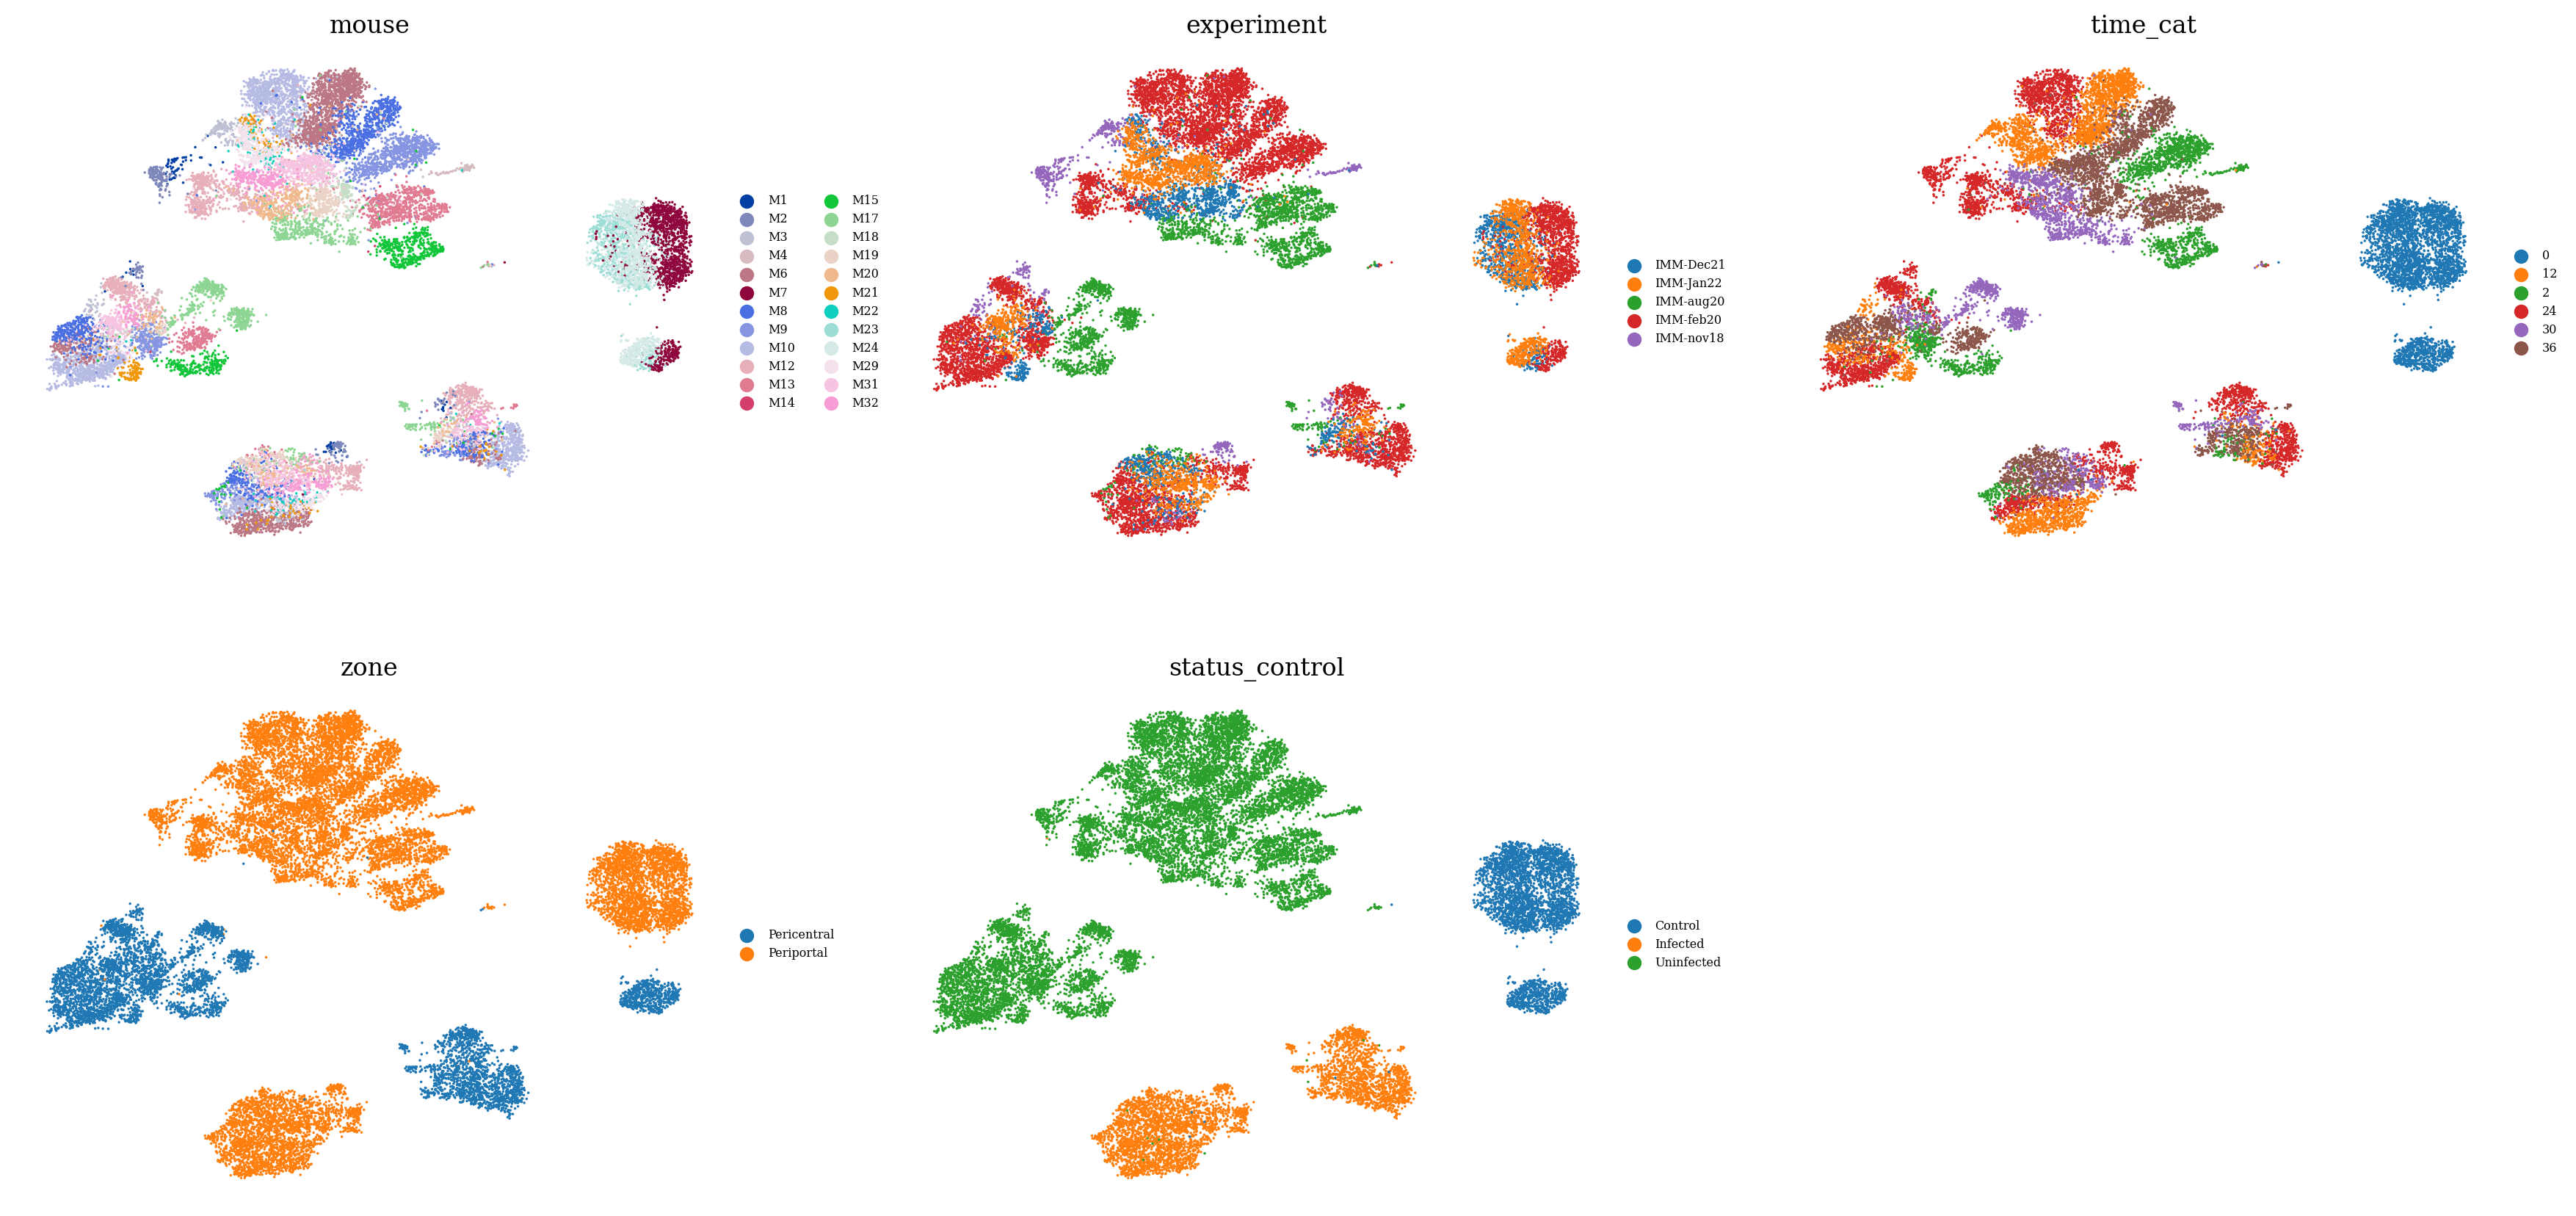

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

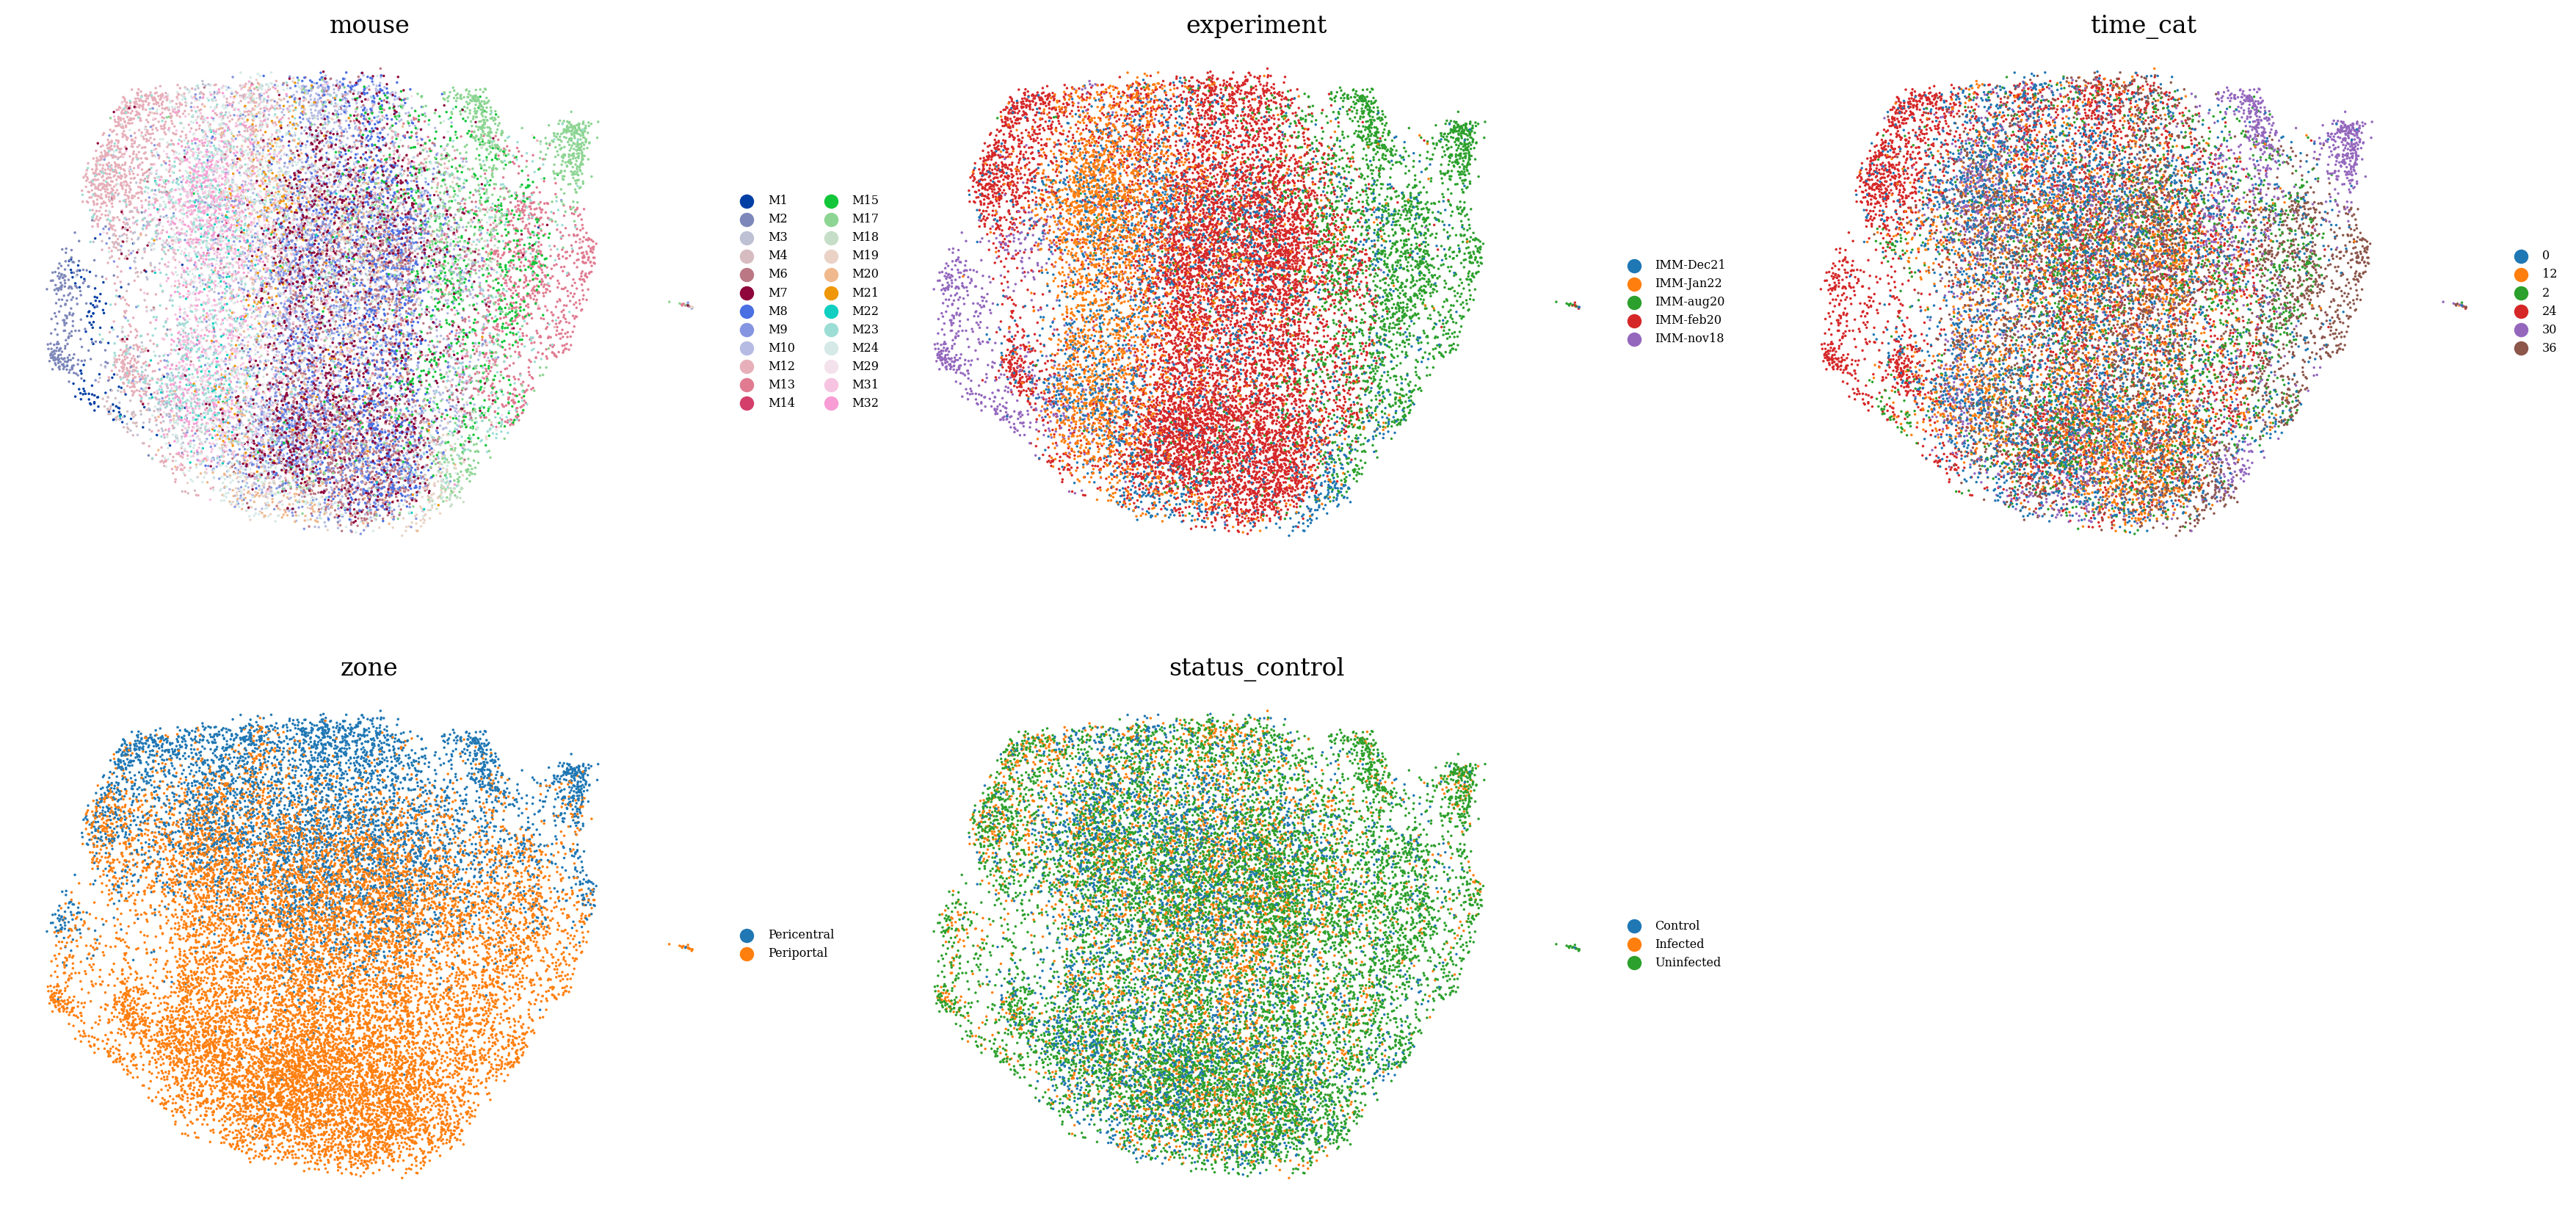

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  5%|▌         | 30/596 [00:00<00:01, 295.23it/s]

 10%|█         | 62/596 [00:00<00:01, 306.13it/s]

 16%|█▌        | 94/596 [00:00<00:01, 310.16it/s]

 21%|██        | 126/596 [00:00<00:01, 309.28it/s]

 27%|██▋       | 158/596 [00:00<00:01, 309.73it/s]

 32%|███▏      | 189/596 [00:00<00:01, 309.12it/s]

 37%|███▋      | 220/596 [00:00<00:01, 309.16it/s]

 42%|████▏     | 251/596 [00:00<00:01, 308.99it/s]

 47%|████▋     | 282/596 [00:00<00:01, 308.77it/s]

 53%|█████▎    | 313/596 [00:01<00:00, 308.22it/s]

 58%|█████▊    | 344/596 [00:01<00:00, 308.32it/s]

 63%|██████▎   | 375/596 [00:01<00:00, 308.50it/s]

 68%|██████▊   | 406/596 [00:01<00:00, 307.92it/s]

 73%|███████▎  | 437/596 [00:01<00:00, 307.91it/s]

 79%|███████▊  | 468/596 [00:01<00:00, 308.53it/s]

 84%|████████▎ | 499/596 [00:01<00:00, 308.77it/s]

 89%|████████▉ | 531/596 [00:01<00:00, 309.14it/s]

 94%|█████████▍| 562/596 [00:01<00:00, 309.11it/s]

 99%|█████████▉| 593/596 [00:01<00:00, 309.11it/s]

100%|██████████| 596/596 [00:01<00:00, 308.40it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

In [23]:
np.mean(r2s)

0.9811165978373858

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)